In [ ]:
!pip install optuna xfeat japanize-matplotlib >> /dev/null

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas_profiling as pdp
from scipy.stats import norm
import seaborn as sns
import statsmodels.api as sm
import math
from scipy import stats
from scipy.special import boxcox, inv_boxcox
import re
import folium
import warnings
%matplotlib inline
from glob import glob
import japanize_matplotlib

warnings.simplefilter('ignore', FutureWarning)
# Set Display Max Columns
pd.set_option("display.max_columns", 50)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 各種関数

In [ ]:
# 欠損値をplotする
def missing_plot(df):
    cols_has_null = df.isnull().sum().to_frame(name="count").query("count > 0").index
    plt.figure(figsize=(10,4))
    cmap = sns.color_palette("deep", 2)
    ax = sns.heatmap(df[cols_has_null].isnull(), cmap=cmap)
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0, 1])
    colorbar.set_ticklabels(['Not Missing','Missing'])
    plt.title("Missing Values")
    plt.show()
    
#カテゴリーの説明変数の確認とプロット
def category(x,df):

    unit = df.groupby([x]).PRICE.mean()
    display(unit)

    unit_count = df.groupby([x]).PRICE.count()
    display(unit_count)

    unit.plot(kind="bar")
    plt.show()

#正規分布の確認
def check_norm(x):
    plt.hist(x, bins=100)#ヒストグラム表示
    plt.pause(.01)
    stats.probplot(x, dist="norm", plot=plt)#QQプロット表示
    plt.pause(.01)
    p=stats.shapiro(x)#シャピロウィルク検定
    print(p)

def null_check(x,df):
    print("【"+str(x)+"】"+"Train欠損値数:" + str(df[x].isnull().sum()))
    print("【"+str(x)+"】"+"Test欠損値数:" + str(df[x].isnull().sum()))
    

#データ統計量の確認
def get_cat_num_features(df):
    
    num_features = []
    cat_features = []
    
    for col in df.columns:
        if df[col].dtype == "float64":
            num_features.append(col)
        if df[col].dtype == "int64":
            num_features.append(col)
            
        if df[col].dtype == "object":
            cat_features.append(col)
            
    return num_features, cat_features


def get_unique_df(features):
    unique_df = pd.DataFrame(columns=['Feature', 'Unique', 'Count'])
    for col in features.columns:
        v = features[col].unique()
        l = len(v)
        unique_df = unique_df.append({'Feature':col, 
                                     'Unique':v,
                                     'Count':l}, ignore_index=True)
    return unique_df


def get_null_df(features):
    col_null_df = pd.DataFrame(columns = ['Column', 'Type', 'Total NaN', '%'])
    col_null = features.columns[features.isna().any()].to_list()
    L = len(features)
    for col in col_null:
        T = 0
        if features[col].dtype == "float64":
            T = "Numerical"  
        elif features[col].dtype == "int64":
            T = "Numerical"  
        else:
            T = "Categorical"
        nulls = len(features[features[col].isna() == True][col])   
        col_null_df = col_null_df.append({'Column': col, 
                                          'Type': T,
                                          'Total NaN': nulls,
                                          '%': (nulls / L)*100
                                         }, ignore_index=True)
        
    return col_null_df

def summary(data,target):
    
    print("Samples --> ", len(data))
    print()
    features = data.drop(target, axis=1)
    print("Features --> ", len(features.columns))
    print("\n",features.columns)
    
    num_features, cat_features = get_cat_num_features(features)
      
    print()
    print("\nNumerical Features --> ", len(num_features))
    print()
    print(num_features)
    print()
    print("Categorical Features -->", len(cat_features))
    print()
    print(cat_features)
    print()
    print("*************************************************")
    stats = features.describe().T
    
    print()
    print("Value counts of each categorical feature\n")
    for col in cat_features:
        print(col)
        print(features[col].value_counts())
        print()
        
    unique_df = get_unique_df(features)
    
    col_null_df = get_null_df(features)
    
    return {'features':features, 
            'target': target, 
            'stats': stats, 
            'unique_df':unique_df,
            'col_null_df': col_null_df}

# yyplot 作成関数
def yyplot(y_obs, y_pred):
    yvalues = np.concatenate([y_obs, y_pred])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('y_observed', fontsize=24)
    plt.ylabel('y_predicted', fontsize=24)
    plt.title('Observed-Predicted Plot', fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

def dist_tt(x):
    g=sns.FacetGrid(df_all,hue="D_TYPE",height=5)
    g.map(sns.distplot,x)
    #g.set(xlim=(0,xlim),ylim=(0,ylim))
    g.add_legend()

def hist_tt(x):
    sns.histplot(train_df_all[x])
    sns.histplot(test_df_all[x])


# データの前処理

## データ読み込み

In [ ]:
cd drive/MyDrive/07_Nishika/fudosan

[Errno 2] No such file or directory: 'drive/MyDrive/07_Nishika/fudosan'
/content


In [ ]:
paths = glob('data/train/*')

train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv('data/test.csv')

ValueError: ignored

In [ ]:
train_df.columns

In [ ]:
train_df.info()

NameError: ignored

In [ ]:
df_summary = summary(train_df, target='取引価格（総額）_log')

Samples -->  662799

Features -->  27

 Index(['ID', '種類', '地域', '市区町村コード', '都道府県名', '市区町村名', '地区名', '最寄駅：名称',
       '最寄駅：距離（分）', '間取り', '面積（㎡）', '土地の形状', '間口', '延床面積（㎡）', '建築年', '建物の構造',
       '用途', '今後の利用目的', '前面道路：方位', '前面道路：種類', '前面道路：幅員（ｍ）', '都市計画', '建ぺい率（％）',
       '容積率（％）', '取引時点', '改装', '取引の事情等'],
      dtype='object')


Numerical Features -->  11

['ID', '地域', '市区町村コード', '土地の形状', '間口', '延床面積（㎡）', '前面道路：方位', '前面道路：種類', '前面道路：幅員（ｍ）', '建ぺい率（％）', '容積率（％）']

Categorical Features --> 16

['種類', '都道府県名', '市区町村名', '地区名', '最寄駅：名称', '最寄駅：距離（分）', '間取り', '面積（㎡）', '建築年', '建物の構造', '用途', '今後の利用目的', '都市計画', '取引時点', '改装', '取引の事情等']

*************************************************

Value counts of each categorical feature

種類
中古マンション等    662799
Name: 種類, dtype: int64

都道府県名
東京都     198606
神奈川県     94597
大阪府      74866
兵庫県      40521
埼玉県      40080
千葉県      34501
愛知県      31767
福岡県      31168
北海道      22474
京都府      15691
宮城県      10275
静岡県       6668
広島県       5532
奈良県       4979
新潟県      

In [ ]:
df_summary['unique_df'][df_summary['unique_df']['Count'] == 1]

,Feature,Unique,Count
1,種類,[中古マンション等],1
2,地域,[nan],1
11,土地の形状,[nan],1
12,間口,[nan],1
13,延床面積（㎡）,[nan],1
18,前面道路：方位,[nan],1
19,前面道路：種類,[nan],1
20,前面道路：幅員（ｍ）,[nan],1


In [ ]:
df_summary['col_null_df']

,Column,Type,Total NaN,%
0,地域,Numerical,662799,100.000000
1,地区名,Categorical,658,0.099276
2,最寄駅：名称,Categorical,2650,0.399820
3,最寄駅：距離（分）,Categorical,23076,3.481598
4,間取り,Categorical,22954,3.463192
5,土地の形状,Numerical,662799,100.000000
6,間口,Numerical,662799,100.000000
7,延床面積（㎡）,Numerical,662799,100.000000
8,建築年,Categorical,19127,2.885792
9,建物の構造,Categorical,15595,2.352900


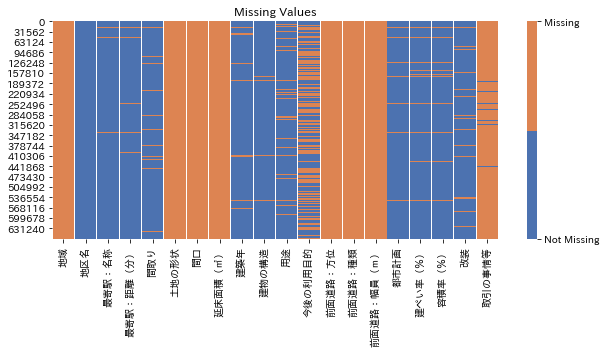

In [ ]:
missing_plot(train_df)

## PRICE

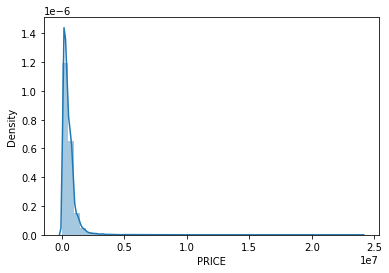

In [ ]:
sns.distplot(train_df_all["PRICE"])

In [ ]:
train_df_all = train_df_all.sort_values("SALEDATE", ascending=True)
train_df_all = train_df_all.drop_duplicates(subset=["PRICE","X","Y"],keep="last")
train_df_all

,Id,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,CMPLX_NUM,LIVING_GBA,FULLADDRESS,CITY,STATE,ZIPCODE,NATIONALGRID,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT,PRICE
0,0,1,0,Hot Water Rad,N,1.0,6,3,1929.0,NaN,1954,2.00,1982-06-11,Q,1,1088.0,1,2 Story,Semi-Detached,Average,Average,Common Brick,Built Up,Hardwood,1.0,0,13,1789,2018-07-22 18:01:43,NaN,NaN,612 TEWKESBURY PLACE NW,WASHINGTON,DC,20012.0,18S UJ 24842 15144,38.967772,-77.021797,Brightwood,006 D Brightwood,1901.0,001901 4012,Ward 4,3197,-77.021356,38.967781,NW,60000.0
1,1,1,1,Warm Cool,Y,1.0,7,3,1940.0,NaN,1947,2.50,1984-05-31,U,3,1276.0,1,2.5 Story Fin,Single,Above Average,Average,Common Brick,Slate,Hardwood,1.0,1,12,4193,2018-07-22 18:01:43,NaN,NaN,4317 20TH STREET NE,WASHINGTON,DC,20018.0,18S UJ 28755 12246,38.942446,-76.975936,Michigan Park,NaN,9400.0,009400 1008,Ward 5,4232,-76.974953,38.942327,NE,75500.0
3,3,3,0,Hot Water Rad,N,1.0,6,3,1925.0,NaN,1950,2.75,1985-08-05,Q,3,1700.0,1,3 Story,Row Inside,Good Quality,Average,Common Brick,Metal- Sms,Hardwood,1.0,0,11,1876,2018-07-22 18:01:43,NaN,NaN,2753 WOODLEY PLACE NW,WASHINGTON,DC,20008.0,18S UJ 22127 10659,38.926829,-77.051948,Garfield,NaN,501.0,000501 1007,Ward 3,2206,-77.051444,38.926412,NW,173000.0
5,5,1,2,Warm Cool,Y,1.0,6,3,1977.0,1985.0,1983,3.00,1986-12-02,Q,1,1870.0,1,3 Story,Row End,Average,Average,Shingle,Shake,Hardwood,1.0,0,11,1159,2018-07-22 18:01:43,NaN,NaN,1910 1/2 NAYLOR ROAD SE,WASHINGTON,DC,20020.0,18S UJ 28470 04560,38.873170,-76.977293,Anacostia,002 B Anacostia,7601.0,007601 1004,Ward 8,5565,-76.976512,38.872954,SE,89000.0
7,7,2,0,Hot Water Rad,N,1.0,7,4,1923.0,NaN,1957,2.00,1988-12-11,U,1,1720.0,1,2 Story,Row Inside,Above Average,Average,Common Brick,Metal- Sms,Hardwood,1.0,1,11,2100,2018-07-22 18:01:43,NaN,NaN,3527 HERTFORD PLACE NW,WASHINGTON,DC,20010.0,18S UJ 23554 11560,38.935232,-77.035730,Columbia Heights,015 A Columbia Heights,2801.0,002801 2004,Ward 1,2686,-77.035527,38.935405,NW,140000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82648,82648,2,1,Forced Air,Y,1.0,8,3,1927.0,2012.0,1964,2.00,2016-12-30,Q,5,1056.0,1,2 Story,Row Inside,Average,Very Good,Common Brick,Metal- Sms,Hardwood,1.0,0,11,1360,2018-07-22 18:01:43,NaN,NaN,5102 7TH STREET NW,WASHINGTON,DC,20011.0,18S UJ 24755 13418,38.952206,-77.022357,Petworth,042 B Petworth,2101.0,002101 3005,Ward 4,3149,-77.022995,38.952523,NW,599900.0
82639,82639,2,0,Hot Water Rad,Y,1.0,6,3,1928.0,2004.0,1964,2.00,2016-12-30,Q,4,1106.0,1,2 Story,Single,Average,Good,Wood Siding,Comp Shingle,Hardwood,1.0,0,12,3551,2018-07-22 18:01:43,NaN,NaN,2415 NEWTON STREET NE,WASHINGTON,DC,20018.0,18S UJ 29140 11290,38.933912,-76.971257,Woodridge,056 A Woodridge,9400.0,009400 3018,Ward 5,4292,-76.971260,38.933607,NE,535000.0
82638,82638,2,1,Forced Air,Y,1.0,6,3,1910.0,2016.0,1964,2.00,2016-12-30,Q,4,2276.0,1,2 Story,Single,Average,Good,Brick/Siding,Comp Shingle,Hardwood/Carp,1.0,0,12,5047,2018-07-22 18:01:43,NaN,NaN,4408 LEE STREET NE,WASHINGTON,DC,20019.0,18S UJ 31959 08047,38.905245,-76.937950,Deanwood,018 B Deanwood,7806.0,007806 2011,Ward 7,5157,-76.937645,38.904715,NE,399000.0
82640,82640,1,2,Hot Water Rad,Y,1.0,7,3,1927.0,2011.0,1982,2.00,2016-12-30,Q,3,1508.0,1,2 Story,Row Inside,Good Quality,Good,Stone,Metal- Sms,Hardwood,1.0,1,11,2190,2018-07-22 18:01:43,NaN,NaN,1730 IRVING STREET NW,WASHINGTON,DC,20010.0,18S UJ 23137 10833,38.928604,-77.040346,Mt. Pleasant,036 B Mt. Pleasant,2702.0,002702 2004,Ward 1,2588,-77.041043,38.928171,NW,937000.0


In [ ]:
train_df_all["SALEDATE"] = pd.to_datetime(train_df_all["SALEDATE"])
train_df_all["SALEDATE_YEAR"] =train_df_all["SALEDATE"].apply(lambda x : x.year).astype(float)
train_df_all["SALEDATE_MONTH"] =train_df_all["SALEDATE"].apply(lambda x : x.month).astype(float)

SALEDATE_YEAR
1982.0    6.000000e+04
1984.0    7.550000e+04
1985.0    1.730000e+05
1986.0    8.900000e+04
1988.0    1.400000e+05
1990.0    1.178333e+05
1991.0    1.412500e+06
1992.0    2.332614e+05
1993.0    2.170385e+05
1994.0    2.168208e+05
1995.0    2.203474e+05
1996.0    2.184684e+05
1997.0    2.340100e+05
1998.0    2.246992e+05
1999.0    2.529113e+05
2000.0    2.614396e+05
2001.0    2.979649e+05
2002.0    3.347205e+05
2003.0    4.083708e+05
2004.0    4.469971e+05
2005.0    5.628461e+05
2006.0    5.660210e+05
2007.0    6.177053e+05
2008.0    5.978300e+05
2009.0    5.608718e+05
2010.0    5.967836e+05
2011.0    5.997208e+05
2012.0    6.450591e+05
2013.0    7.130317e+05
2014.0    7.299661e+05
2015.0    7.724950e+05
2016.0    7.778911e+05
Name: PRICE, dtype: float64

SALEDATE_YEAR
1982.0       1
1984.0       1
1985.0       1
1986.0       1
1988.0       1
1990.0       3
1991.0       2
1992.0     648
1993.0     544
1994.0     673
1995.0     639
1996.0     736
1997.0     925
1998.0    1108
1999.0    1236
2000.0    1581
2001.0    1744
2002.0    1830
2003.0    1887
2004.0    2167
2005.0    2046
2006.0    1849
2007.0    1957
2008.0    1602
2009.0    2021
2010.0    2210
2011.0    2392
2012.0    2626
2013.0    3109
2014.0    3357
2015.0    3724
2016.0    4176
Name: PRICE, dtype: int64

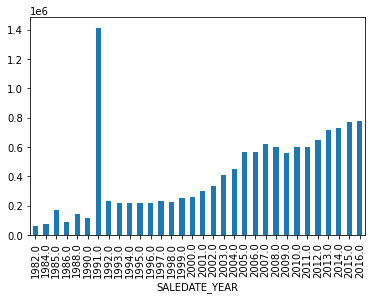

In [ ]:
category("SALEDATE_YEAR",train_df_all)

In [ ]:
#train_df_all = train_df_all[train_df_all["SALEDATE_YEAR"] > 2000]

In [ ]:
train_df_all = train_df_all.sort_values("Id", ascending=True)

In [ ]:
train_df_all[train_df_all.duplicated(subset=["PRICE","X","Y"])]

,Id,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,CMPLX_NUM,LIVING_GBA,FULLADDRESS,CITY,STATE,ZIPCODE,NATIONALGRID,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT,PRICE,SALEDATE_YEAR,SALEDATE_MONTH


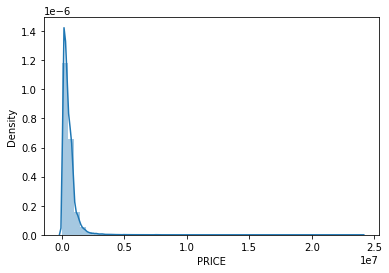

In [ ]:
sns.distplot(train_df_all["PRICE"])

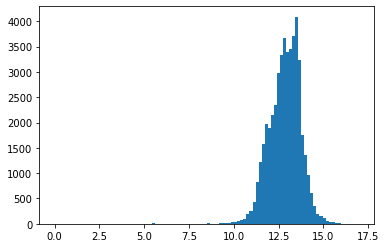

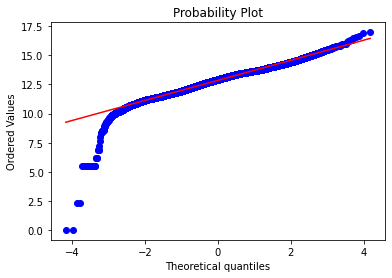

(0.9731425642967224, 0.0)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
temp = train_df_all.copy()
temp["PRICE"] = np.log(temp["PRICE"])
check_norm(temp["PRICE"])

In [ ]:
#train_df_all = train_df_all[train_df_all["PRICE"] < 5000000]

In [ ]:
#sns.distplot(train_df_all["PRICE"])

## QUALIFIED

QUALIFIED
Q    596101.787872
U    356023.144287
Name: PRICE, dtype: float64

QUALIFIED
Q    36907
U     9890
Name: PRICE, dtype: int64

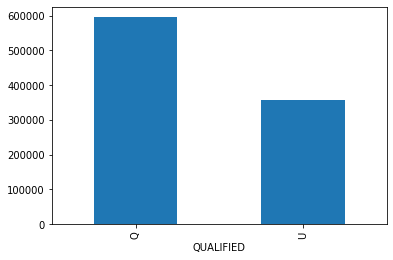

In [ ]:
#CNDTNの欠損値補完
category("QUALIFIED",train_df_all)

In [ ]:
#a = train_df_all[train_df_all["QUALIFIED"]=="Q"].reset_index(drop=True)
#b = train_df_all[train_df_all["QUALIFIED"]=="U"].reset_index(drop=True)
#b["PRICE"] = b["PRICE"]*1.53
#train_df_all = pd.concat([a,b],axis=0).reset_index(drop=True)

QUALIFIED
Q    596101.787872
U    356023.144287
Name: PRICE, dtype: float64

QUALIFIED
Q    36907
U     9890
Name: PRICE, dtype: int64

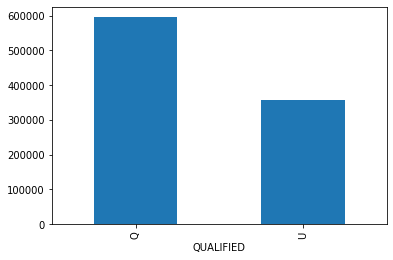

In [ ]:
category("QUALIFIED",train_df_all)

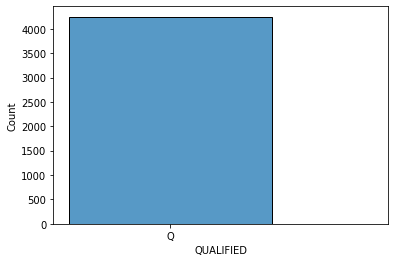

In [ ]:
sns.histplot(test_df_all["QUALIFIED"])

In [ ]:
train_df_all = train_df_all.copy()
train_df_all = train_df_all[train_df_all["QUALIFIED"] == "Q"]

## ROOF

ROOF
Built Up          4.946975e+05
Clay Tile         1.067864e+06
Comp Shingle      5.304458e+05
Composition Ro    5.699161e+05
Concrete Tile     3.927359e+06
Metal- Cpr        1.440807e+06
Metal- Pre        5.551422e+05
Metal- Sms        5.953603e+05
Neopren           8.071089e+05
Shake             7.556155e+05
Shingle           8.448085e+05
Slate             9.531765e+05
Typical           4.281149e+05
Water Proof       5.940000e+05
Wood- FS          9.800000e+05
Name: PRICE, dtype: float64

ROOF
Built Up          10829
Clay Tile           208
Comp Shingle       9960
Composition Ro       43
Concrete Tile         4
Metal- Cpr           15
Metal- Pre           83
Metal- Sms        10613
Neopren             686
Shake               255
Shingle             163
Slate              3985
Typical              58
Water Proof           2
Wood- FS              3
Name: PRICE, dtype: int64

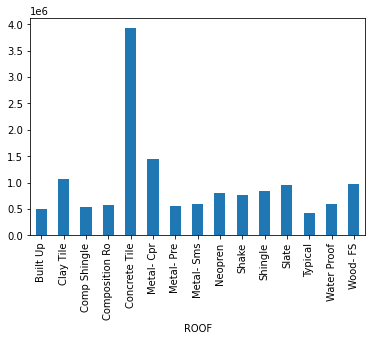

In [ ]:
category("ROOF",train_df_all)

## EXT_WALL

EXTWALL
Adobe             1.050000e+05
Aluminum          3.914063e+05
Brick Veneer      7.778328e+05
Brick/Siding      5.293234e+05
Brick/Stone       9.460009e+05
Brick/Stucco      8.177685e+05
Common Brick      5.772735e+05
Concrete          6.791950e+05
Concrete Block    6.422247e+05
Default           5.043000e+05
Face Brick        5.529693e+05
Hardboard         1.108698e+06
Metal Siding      5.521333e+05
Plywood           4.975000e+05
Shingle           5.460511e+05
Stone             1.189288e+06
Stone Veneer      5.128386e+05
Stone/Siding      1.067949e+06
Stone/Stucco      1.393901e+06
Stucco            8.741016e+05
Stucco Block      7.183657e+05
Vinyl Siding      3.525053e+05
Wood Siding       8.157781e+05
Name: PRICE, dtype: float64

EXTWALL
Adobe                 1
Aluminum            274
Brick Veneer        351
Brick/Siding       2259
Brick/Stone         275
Brick/Stucco        279
Common Brick      27944
Concrete             20
Concrete Block       22
Default               5
Face Brick          290
Hardboard            38
Metal Siding         15
Plywood               1
Shingle             328
Stone               242
Stone Veneer         96
Stone/Siding        150
Stone/Stucco        110
Stucco             1076
Stucco Block         16
Vinyl Siding       1640
Wood Siding        1475
Name: PRICE, dtype: int64

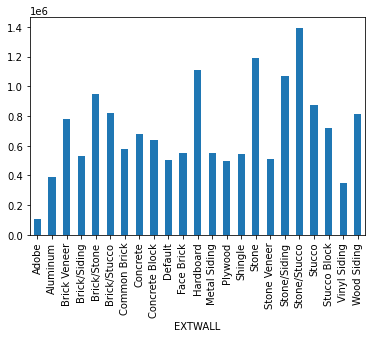

In [ ]:
category("EXTWALL",train_df_all)

## STORIES

STORIES
0.00      3.807667e+05
1.00      4.359334e+05
1.25      4.007860e+05
1.50      5.252085e+05
1.70      1.262500e+06
1.75      6.387780e+05
2.00      5.018695e+05
2.20      1.210600e+06
2.25      7.302685e+05
2.30      7.000000e+05
2.50      1.102587e+06
2.70      3.150714e+06
2.75      1.750162e+06
3.00      9.041988e+05
3.25      2.565625e+06
3.50      1.303606e+06
3.75      1.580584e+06
4.00      1.545086e+06
5.00      7.531667e+05
6.00      8.708333e+05
7.00      4.500000e+05
8.25      6.050000e+05
9.00      2.106000e+05
25.00     1.085000e+06
250.00    1.459000e+06
826.00    7.600000e+05
Name: PRICE, dtype: float64

STORIES
0.00          6
1.00       1218
1.25        132
1.50        611
1.70          2
1.75        388
2.00      27328
2.20          5
2.25        918
2.30          1
2.50       2311
2.70          7
2.75        191
3.00       3560
3.25          8
3.50         42
3.75          6
4.00        142
5.00          6
6.00          3
7.00          1
8.25          1
9.00          5
25.00         2
250.00        1
826.00        1
Name: PRICE, dtype: int64

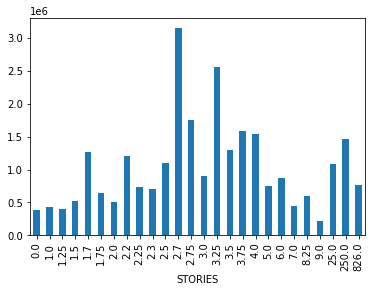

In [ ]:
category("STORIES",train_df_all)

In [ ]:
train_df_all["STORIES"] = train_df_all["STORIES"].fillna(train_df_all["STORIES"].mode()[0])
test_df_all["STORIES"] = test_df_all["STORIES"].fillna(test_df_all["STORIES"].mode()[0])

In [ ]:
train_df_all["STORIES"].unique()

array([  2.  ,   2.75,   3.  ,   1.5 ,   2.5 ,   1.75,   1.  ,   2.25,
         4.  ,   1.25,   9.  ,   3.5 ,   2.7 ,   2.2 ,   3.75,   6.  ,
         0.  ,   5.  ,   3.25,   7.  ,   2.3 ,  25.  , 826.  ,   8.25,
       250.  ,   1.7 ])

## STYLE

STYLE
1 Story            4.321665e+05
1.5 Story Fin      5.049000e+05
1.5 Story Unfin    4.819091e+05
2 Story            5.045614e+05
2.5 Story Fin      1.097686e+06
2.5 Story Unfin    6.421347e+05
3 Story            9.453830e+05
3.5 Story Fin      1.206617e+06
3.5 Story Unfin    2.359044e+06
4 Story            1.598419e+06
4.5 Story Fin      2.500000e+06
4.5 Story Unfin    4.900000e+05
Bi-Level           7.109375e+05
Default            5.989108e+05
Split Foyer        2.999847e+05
Split Level        6.240683e+05
Vacant             1.125000e+06
Name: PRICE, dtype: float64

STYLE
1 Story             1130
1.5 Story Fin        717
1.5 Story Unfin       35
2 Story            27985
2.5 Story Fin       2725
2.5 Story Unfin      256
3 Story             3647
3.5 Story Fin         53
3.5 Story Unfin        5
4 Story              139
4.5 Story Fin          1
4.5 Story Unfin        1
Bi-Level               8
Default                8
Split Foyer           78
Split Level          118
Vacant                 1
Name: PRICE, dtype: int64

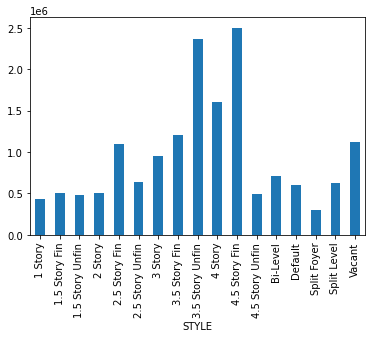

In [ ]:
category("STYLE",train_df_all)

## STRUCT

STRUCT
Default          1.537500e+06
Multi            3.771588e+05
Row End          5.891165e+05
Row Inside       5.645337e+05
Semi-Detached    3.974576e+05
Single           7.669399e+05
Town End         4.187119e+05
Town Inside      4.309272e+05
Name: PRICE, dtype: float64

STRUCT
Default              1
Multi             1361
Row End           4351
Row Inside       15174
Semi-Detached     5081
Single           10783
Town End            51
Town Inside        105
Name: PRICE, dtype: int64

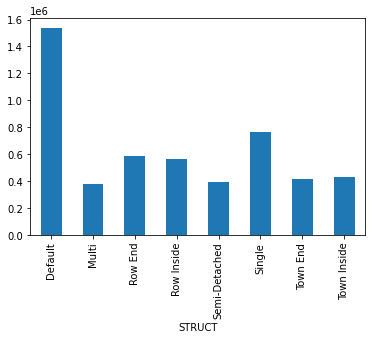

In [ ]:
category("STRUCT",train_df_all)

In [ ]:
train_df_all = train_df_all[train_df_all["STRUCT"]!="Default"]

In [ ]:
train_df_all["STRUCT"].unique()

array(['Semi-Detached', 'Row Inside', 'Row End', 'Single', 'Multi',
       'Town Inside', 'Town End'], dtype=object)

In [ ]:
test_df_all["STRUCT"].unique()

array(['Row End', 'Semi-Detached', 'Single', 'Row Inside', 'Multi',
       'Town Inside', 'Town End'], dtype=object)

## USECODE

USECODE
11    534351.398707
12    769638.024370
13    387119.787545
15    579944.444444
19    181140.000000
23    349149.224819
24    748645.031160
Name: PRICE, dtype: float64

USECODE
11    16556
12    10628
13     4994
15       18
19        3
23     1241
24     3466
Name: PRICE, dtype: int64

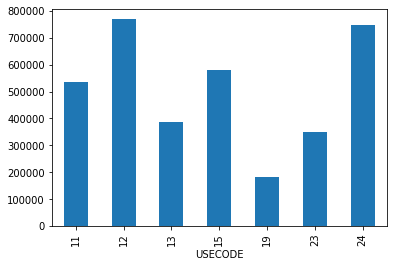

In [ ]:
category("USECODE",train_df_all)

## FULL_ADRESS

In [ ]:
temp = train_df_all["FULLADDRESS"].str.split(" ",expand=True).reset_index()
train_df_all["ADDRESS_LOC"] =temp.iloc[:,3]
train_df_all["ADDRESS_LOC"] = train_df_all["ADDRESS_LOC"].str[:-2]
train_df_all["ADDRESS_LOC"] = train_df_all["ADDRESS_LOC"].fillna("0")

In [ ]:
train_df_all["ADDRESS_LOC"].unique()

array(['PLA', 'STRE', 'RO', 'BUR', 'DRI', 'AVEN', 'VIS', 'JERS', 'BRAN',
       'NE', 'COU', 'HO', '0', 'HAMPSHI', 'TERRA', 'CAROLI', 'CAPIT',
       'CHA', 'CRESCE', 'DAV', 'HEL', 'PARKW', 'CIRC', 'MI', 'DAKO',
       'SQUA', 'LUTH', 'BOULEVA', 'CHAP', 'LA', '', 'WA', 'BAK', 'DUPO',
       'CRE', 'BEA', 'ISLA', '3', 'ACK', '12', 'KNOL', 'MEXI', 'HAZ',
       'CALVE', 'BRID', 'PA', 'PORT', 'VI', 'PLEASA', 'ME', 'SWA', '18',
       'EA', '21', '7', 'SHERM', '17', 'ANN', 'STEVE', 'VIRGIN', 'RIV',
       'MARYLA', '9', 'CHUR', '15', 'COLORA', 'WYL', 'STRO', 'ONTAR', 'R',
       'HI', 'CONSTITUTI', 'OLIV', 'CORCOR', '6', 'TOTT', 'N', '5', 'GLA',
       'FAIRMO', '19', '13', 'BUCHAN', 'MACARTH', 'WILS', 'MASSACHUSET',
       '4', 'BELMO', 'YO', 'LINCO', 'DOUGLA', 'CLIFT', 'ROBER', '48',
       '16', 'INDEPENDEN', 'GR', 'CALIFORN', 'NANN', 'EDS', 'W', 'SOU',
       'WILLA', 'GILLI', 'SEWA', '11', 'HUNTINGT', 'JOSH', 'DUNC',
       'ELLIS', '2', 'MORT', '22', 'JEFFERS', 'LAMO', 'WILMINGT', '1

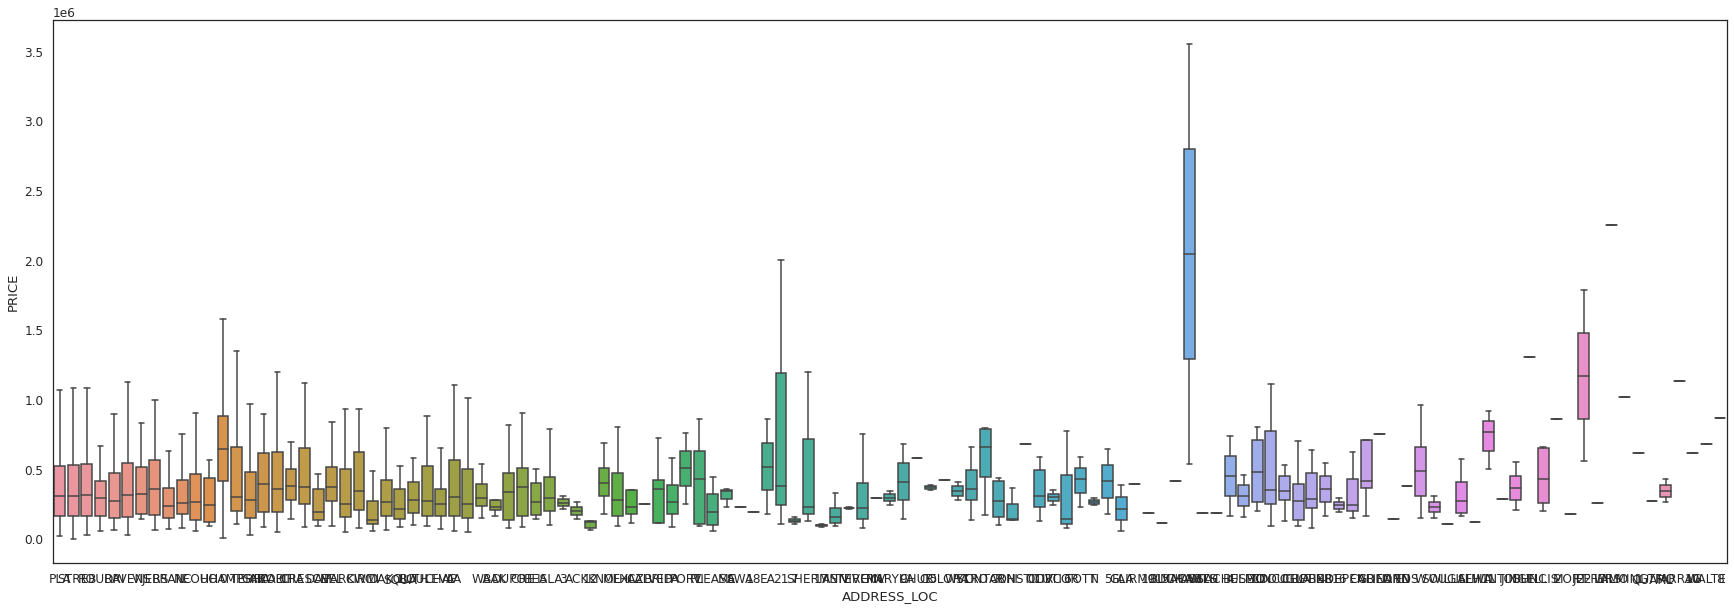

In [ ]:
sns.set(font_scale=1.1)
sns.set_style('white')
fig =plt.figure (figsize = (30,10))

sns.boxplot(data=train_df_all, x="ADDRESS_LOC",y="PRICE",sym="")

## ASSESSMENT_NBHD

ASSESSMENT_NBHD
16th Street Heights             5.527290e+05
American University             7.429644e+05
Anacostia                       2.212414e+05
Barry Farms                     2.047280e+05
Berkley                         1.547095e+06
Brentwood                       2.612808e+05
Brightwood                      4.032994e+05
Brookland                       4.427255e+05
Burleith                        8.755513e+05
Capitol Hill                    7.536344e+05
Central-tri 1                   1.265185e+06
Chevy Chase                     8.008476e+05
Chillum                         3.486930e+05
Cleveland Park                  1.321052e+06
Colonial Village                7.327362e+05
Columbia Heights                4.972921e+05
Congress Heights                2.067059e+05
Crestwood                       7.579177e+05
Deanwood                        2.131558e+05
Eckington                       4.731645e+05
Foggy Bottom                    6.646947e+05
Forest Hills                    1.26627

ASSESSMENT_NBHD
16th Street Heights              663
American University              962
Anacostia                        472
Barry Farms                       97
Berkley                          311
Brentwood                        238
Brightwood                      1188
Brookland                       1643
Burleith                         281
Capitol Hill                    1271
Central-tri 1                     72
Chevy Chase                     2003
Chillum                          251
Cleveland Park                   402
Colonial Village                 181
Columbia Heights                1784
Congress Heights                 988
Crestwood                        253
Deanwood                        1558
Eckington                        619
Foggy Bottom                      95
Forest Hills                     295
Fort Dupont Park                 866
Fort Lincoln                     381
Foxhall                          173
Garfield                         210
Georgetown            

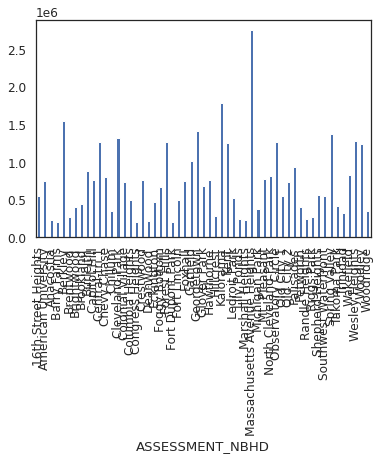

In [ ]:
category("ASSESSMENT_NBHD",train_df_all)

In [ ]:
temp_a = train_df_all.groupby("ASSESSMENT_NBHD").PRICE.mean().reset_index().sort_values("PRICE",ascending=True).reset_index(drop=True)

In [ ]:
neibor_dict = dict(zip(list(temp_a["ASSESSMENT_NBHD"]),list(temp_a.index)))

In [ ]:
def fill_neighbors(x):
    x=neibor_dict[x]
    return x

train_df_all["ASSESSMENT_NBHD"] = train_df_all["ASSESSMENT_NBHD"].apply(lambda x:fill_neighbors(x)).astype(int)
test_df_all["ASSESSMENT_NBHD"] = test_df_all["ASSESSMENT_NBHD"].apply(lambda x:fill_neighbors(x)).astype(int)

ASSESSMENT_SUBNBHD
001 A American University    701862.439024
001 B American University    708752.419204
001 C American University    800509.549865
002 A Anacostia              214447.801020
002 B Anacostia              226065.920290
                                 ...      
054 B Wesley Heights         759344.990385
056 A Woodridge              359969.818482
056 B Woodridge              337090.726667
056 C Woodridge              341371.115942
056 D Woodridge              339969.647059
Name: PRICE, Length: 121, dtype: float64

ASSESSMENT_SUBNBHD
001 A American University    164
001 B American University    427
001 C American University    371
002 A Anacostia              196
002 B Anacostia              276
                            ... 
054 B Wesley Heights         104
056 A Woodridge              303
056 B Woodridge              150
056 C Woodridge              276
056 D Woodridge               51
Name: PRICE, Length: 121, dtype: int64

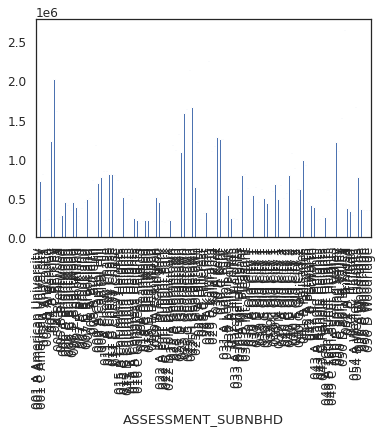

In [ ]:
category("ASSESSMENT_SUBNBHD",train_df_all)

In [ ]:
train_df_all["ASSESSMENT_SUBNBHD"] =train_df_all["ASSESSMENT_SUBNBHD"].fillna("None")

In [ ]:
train_df_all[train_df_all["ASSESSMENT_SUBNBHD"].str.contains("University")]

,Id,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,...,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,CMPLX_NUM,LIVING_GBA,FULLADDRESS,CITY,STATE,ZIPCODE,NATIONALGRID,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT,PRICE,SALEDATE_YEAR,SALEDATE_MONTH,ADDRESS_LOC
19,19,2,0,Warm Cool,Y,1.0,8,4,1938.0,NaN,1961,2.0,1992-01-02,Q,1,1388.0,1,2 Story,Single,Very Good,Good,Common Brick,Slate,Hardwood,1.0,...,12,4950,2018-07-22 18:01:43,NaN,NaN,4912 45TH STREET NW,WASHINGTON,DC,20016.0,18S UJ 18992 13732,38.953865,-77.088904,32,001 B American University,1001.0,001001 5002,Ward 3,1572,-77.089753,38.954024,NW,295000.0,1992.0,1.0,PLA
21,21,1,0,Hot Water Rad,Y,1.0,5,2,1936.0,NaN,1960,2.0,1992-01-03,Q,1,1117.0,1,2 Story,Single,Good Quality,Average,Common Brick,Comp Shingle,Hardwood,1.0,...,12,3638,2018-07-22 18:01:43,NaN,NaN,4429 RIVER ROAD NW,WASHINGTON,DC,20016.0,18S UJ 19116 13751,38.954067,-77.087480,32,001 A American University,1001.0,001001 2003,Ward 3,1583,-77.086967,38.954092,NW,202000.0,1992.0,1.0,STRE
41,41,2,1,Warm Cool,Y,1.0,8,3,1939.0,2002.0,1954,2.0,1992-01-13,Q,1,3118.0,1,2 Story,Single,Very Good,Very Good,Brick/Siding,Slate,Hardwood,1.0,...,12,4950,2018-07-22 18:01:43,NaN,NaN,4716 44TH STREET NW,WASHINGTON,DC,20016.0,18S UJ 19194 13486,38.951689,-77.086507,32,001 B American University,1001.0,001001 2019,Ward 3,1586,-77.087421,38.951580,NW,280000.0,1992.0,1.0,STRE
49,49,2,1,Warm Cool,Y,1.0,7,3,1939.0,NaN,1954,2.0,1992-01-17,Q,1,1276.0,1,2 Story,Single,Very Good,Average,Common Brick,Slate,Hardwood,1.0,...,12,4950,2018-07-22 18:01:43,NaN,NaN,4720 44TH STREET NW,WASHINGTON,DC,20016.0,18S UJ 19196 13499,38.951813,-77.086494,32,001 B American University,1001.0,001001 2019,Ward 3,1586,-77.087421,38.951580,NW,232500.0,1992.0,1.0,PLA
89,89,2,0,Warm Cool,Y,1.0,7,3,1934.0,NaN,1954,2.0,1992-02-05,Q,1,1736.0,1,2 Story,Single,Very Good,Good,Common Brick,Slate,Hardwood,1.0,...,12,3850,2018-07-22 18:01:43,NaN,NaN,4413 BRANDYWINE STREET NW,WASHINGTON,DC,20016.0,18S UJ 19149 13287,38.949890,-77.086980,32,001 B American University,1001.0,001001 2026,Ward 3,1587,-77.087335,38.950525,NW,275000.0,1992.0,2.0,STRE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81858,81858,2,1,Forced Air,Y,1.0,8,3,1938.0,2011.0,1969,2.0,2016-11-28,Q,5,1752.0,1,2 Story,Single,Good Quality,Good,Common Brick,Slate,Hardwood,1.0,...,12,5610,2018-07-22 18:01:43,NaN,NaN,4605 ALTON PLACE NW,WASHINGTON,DC,20016.0,18S UJ 18790 13006,38.947286,-77.091040,32,001 C American University,1001.0,001001 6001,Ward 3,1550,-77.091593,38.947495,NW,1300000.0,2016.0,11.0,0
82044,82044,4,1,Warm Cool,Y,1.0,9,4,1945.0,2017.0,1973,2.0,2016-12-05,Q,2,2552.0,1,2 Story,Single,Very Good,Good,Common Brick,Comp Shingle,Hardwood,2.0,...,12,5308,2018-07-22 18:01:43,NaN,NaN,4319 MURDOCK MILL ROAD NW,WASHINGTON,DC,20016.0,18S UJ 19291 13110,38.948327,-77.085299,32,001 B American University,1001.0,001001 2027,Ward 3,1647,-77.085234,38.948803,NW,1140000.0,2016.0,12.0,0
82275,82275,2,1,Warm Cool,Y,1.0,7,3,1926.0,1968.0,1969,2.0,2016-12-13,Q,2,1216.0,1,2 Story,Semi-Detached,Good Quality,Good,Common Brick,Metal- Sms,Hardwood,1.0,...,13,1544,2018-07-22 18:01:43,NaN,NaN,4400 CHESAPEAKE STREET NW,WASHINGTON,DC,20016.0,18S UJ 19202 13392,38.950846,-77.086400,32,001 B American University,1001.0,001001 2018,Ward 3,1587,-77.087335,38.950525,NW,750000.0,2016.0,12.0,0
82430,82430,1,1,Forced Air,Y,1.0,7,3,1929.0,NaN,1969,2.0,2016-12-20,Q,2,1200.0,1,2 Story,Single,Good Quality,Good,Wood Siding,Comp Shingle,Hardwood,1.0,...,12,4500,2018-07-22 18:01:43,NaN,NaN,4311 ELLICOTT STREET NW,WASHINGTON,DC,20016.0,18S UJ 19389 13681,38.953488,-77.084316,32,001 A American University,1001.0,001001 2001,Ward 3,1654

## BLDG_NUM

BLDG_NUM
1    5.959048e+05
2    3.760000e+06
Name: PRICE, dtype: float64

BLDG_NUM
1    36904
2        2
Name: PRICE, dtype: int64

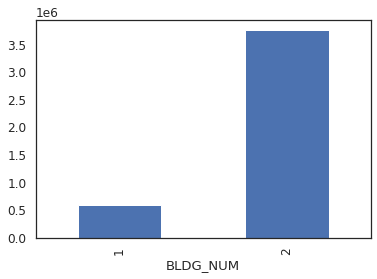

In [ ]:
category("BLDG_NUM",train_df_all)

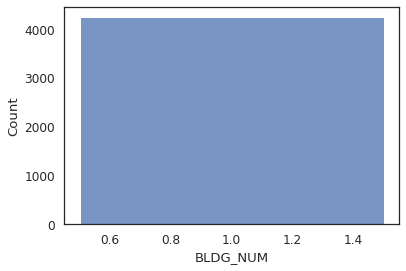

In [ ]:
sns.histplot(test_df_all["BLDG_NUM"])

## ZIPCODE

In [ ]:
train_df_all=train_df_all[train_df_all["ZIPCODE"]!=20052.0]

ZIPCODE
20001.0    5.253442e+05
20002.0    4.976671e+05
20003.0    6.336559e+05
20005.0    8.739647e+05
20007.0    1.179028e+06
20008.0    1.330057e+06
20009.0    8.482727e+05
20010.0    5.897355e+05
20011.0    4.250853e+05
20012.0    5.100301e+05
20015.0    7.961275e+05
20016.0    1.023077e+06
20017.0    4.259929e+05
20018.0    3.858936e+05
20019.0    2.170203e+05
20020.0    2.406801e+05
20024.0    4.598078e+05
20032.0    2.173952e+05
20036.0    1.415090e+06
20037.0    7.899225e+05
Name: PRICE, dtype: float64

ZIPCODE
20001.0    1978
20002.0    5058
20003.0    2687
20005.0      85
20007.0    2471
20008.0    1354
20009.0    1324
20010.0    1514
20011.0    4840
20012.0    1191
20015.0    1973
20016.0    2693
20017.0    1451
20018.0    1656
20019.0    3110
20020.0    2035
20024.0     227
20032.0    1062
20036.0      53
20037.0     138
Name: PRICE, dtype: int64

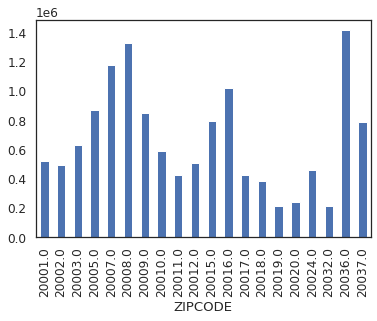

In [ ]:
train_df_all["ZIPCODE"] =train_df_all["ZIPCODE"].astype(str)
test_df_all["ZIPCODE"] =test_df_all["ZIPCODE"].astype(str)
category("ZIPCODE",train_df_all)

In [ ]:
set(train_df_all["ZIPCODE"].unique())^set(test_df_all["ZIPCODE"].unique())

set()

## KITCHEN

KITCHENS
0.0    413530.047619
1.0    568347.994382
2.0    787171.461277
3.0    723218.779614
4.0    425963.414221
5.0    466010.333333
6.0    749166.666667
Name: PRICE, dtype: float64

KITCHENS
0.0       21
1.0    30614
2.0     5010
3.0      363
4.0      886
5.0        3
6.0        3
Name: PRICE, dtype: int64

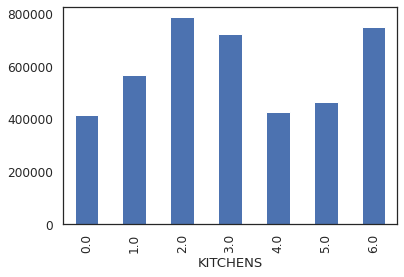

In [ ]:
category("KITCHENS",train_df_all)

## FIREPLACE

FIREPLACES
0     3.948047e+05
1     6.610236e+05
2     9.335212e+05
3     1.365359e+06
4     1.950358e+06
5     2.371888e+06
6     2.290860e+06
7     3.276130e+06
8     4.687500e+06
9     2.706333e+06
10    6.256000e+06
11    3.926500e+06
12    8.600000e+06
13    6.350000e+06
Name: PRICE, dtype: float64

FIREPLACES
0     18966
1     12193
2      4242
3       970
4       329
5       114
6        54
7        18
8         4
9         3
10        2
11        2
12        1
13        2
Name: PRICE, dtype: int64

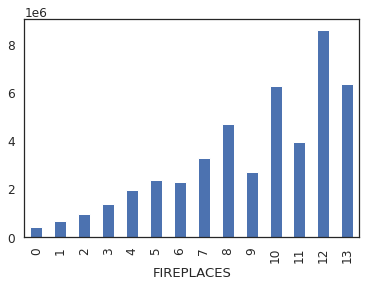

In [ ]:
category("FIREPLACES",train_df_all)

In [ ]:
test_df_all["FIREPLACES"].value_counts()

0    2411
1    1236
2     421
3     104
4      42
5      17
6      14
7       2
Name: FIREPLACES, dtype: int64

In [ ]:
train_df_all = train_df_all.copy()
train_df_all = train_df_all[train_df_all["FIREPLACES"]<8]

## BATHRM/HF_BATHRM

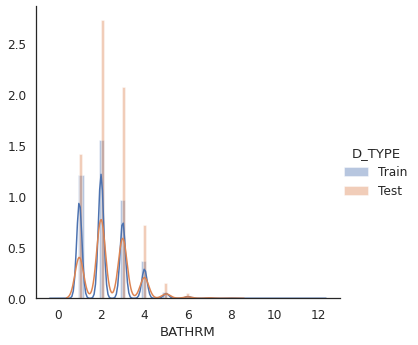

In [ ]:
dist_tt("BATHRM")

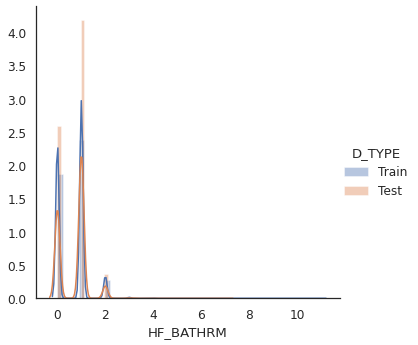

In [ ]:
dist_tt("HF_BATHRM")

In [ ]:
#BATHROOMとHFBATHROOMは合計の値を説明変数にする
train_df_all["BATHRM_ALL"] = train_df_all['BATHRM'] + train_df_all["HF_BATHRM"]
test_df_all["BATHRM_ALL"] = test_df_all['BATHRM'] + test_df_all["HF_BATHRM"]

## ROOMS/BEDROOMS

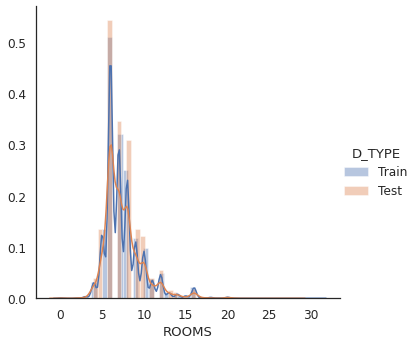

In [ ]:
dist_tt("ROOMS")

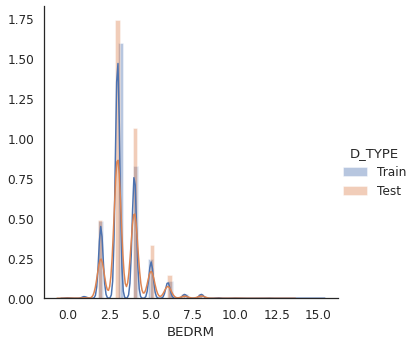

In [ ]:
dist_tt("BEDRM")

In [ ]:
#ROOMの合計はROOMSとBEDRMの合計とする
train_df_all["ROOM_ALL"] = train_df_all['ROOMS'] + train_df_all['BEDRM']
test_df_all["ROOM_ALL"] = test_df_all['ROOMS'] + test_df_all['BEDRM']

## EYB

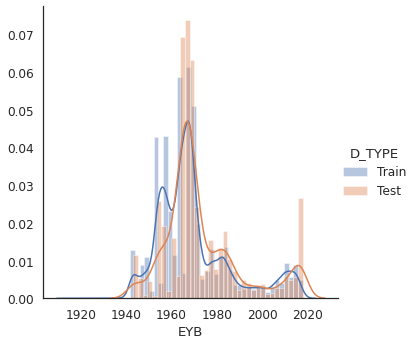

In [ ]:
dist_tt("EYB")

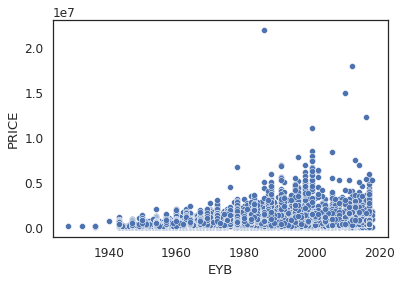

In [ ]:
sns.scatterplot(data=train_df_all,x="EYB",y="PRICE")

## AYB

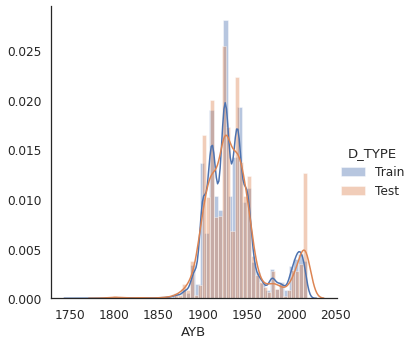

In [ ]:
dist_tt("AYB")

In [ ]:
#AYBの欠損値補完
#ほとんどの場合でAYBとEYBは同じ。AYBの欠損値はEYBで補完
train_df_all["AYB"] = train_df_all["AYB"].fillna(value=train_df_all["EYB"])
test_df_all["AYB"] = test_df_all["AYB"].fillna(value=test_df_all["EYB"])

In [ ]:
train_df_all["AYB"].describe()

count    36886.000000
mean      1933.847340
std         30.277379
min       1765.000000
25%       1912.000000
50%       1928.000000
75%       1947.000000
max       2018.000000
Name: AYB, dtype: float64

In [ ]:
train_df_all['AYB_GROUP']  = train_df_all['AYB'].astype(float)
bins =  [1750] + [i for i in range(1850, 2030, 10)]

labels = []
length = len(bins)-1
for i in range(length):
  label = str(bins[i]) + "-" + str(bins[i+1])
  labels.append(label)

train_df_all['AYB_GROUP'] = pd.cut(train_df_all['AYB'], bins=bins, labels = labels)

AYB_GROUP
1750-1850    1.702387e+06
1850-1860    1.211611e+06
1860-1870    9.658293e+05
1870-1880    8.025078e+05
1880-1890    7.539389e+05
1890-1900    7.836859e+05
1900-1910    5.981001e+05
1910-1920    5.975713e+05
1920-1930    5.822153e+05
1930-1940    5.587797e+05
1940-1950    3.982275e+05
1950-1960    4.979788e+05
1960-1970    6.156830e+05
1970-1980    6.094002e+05
1980-1990    9.532621e+05
1990-2000    7.410593e+05
2000-2010    5.810067e+05
2010-2020    7.167485e+05
Name: PRICE, dtype: float64

AYB_GROUP
1750-1850     100
1850-1860      30
1860-1870     104
1870-1880     231
1880-1890     803
1890-1900    3058
1900-1910    3750
1910-1920    4238
1920-1930    7308
1930-1940    5603
1940-1950    4327
1950-1960    2356
1960-1970     746
1970-1980     680
1980-1990     563
1990-2000     471
2000-2010    1393
2010-2020    1125
Name: PRICE, dtype: int64

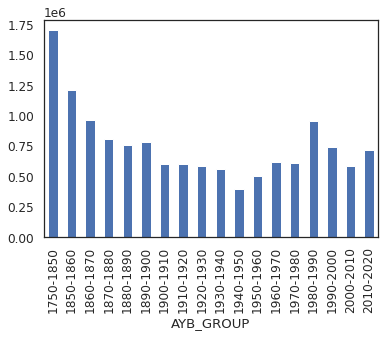

In [ ]:
category("AYB_GROUP",train_df_all)

In [ ]:
test_df_all["AYB"].describe()

count    4247.000000
mean     1935.979515
std        33.261568
min      1790.000000
25%      1913.000000
50%      1929.000000
75%      1948.000000
max      2018.000000
Name: AYB, dtype: float64

In [ ]:
test_df_all['AYB_GROUP']  = test_df_all['AYB'].astype(float)
bins =  [1750] + [i for i in range(1850, 2030, 10)]

labels = []
length = len(bins)-1
for i in range(length):
  label = str(bins[i]) + "-" + str(bins[i+1])
  labels.append(label)

test_df_all['AYB_GROUP'] = pd.cut(test_df_all['AYB'], bins=bins, labels = labels)

## YR_RMDL

In [ ]:
a = train_df_all[["AYB", "AYB_GROUP","YR_RMDL"]]
b = test_df_all[["AYB","AYB_GROUP","YR_RMDL"]]
a = a[~a["YR_RMDL"].isnull()]
b = b[~b["YR_RMDL"].isnull()]

temp_yr = pd.concat([a,b],axis=0)

temp_yr["duration"] = temp_yr["YR_RMDL"] - temp_yr["AYB"]
temp_yr["duration"].describe()

count    25259.000000
mean        80.661863
std         27.255241
min      -1909.000000
25%         66.000000
50%         83.000000
75%         97.000000
max        234.000000
Name: duration, dtype: float64

In [ ]:

temp_yr=temp_yr[temp_yr["duration"] > 0]

fill_rmyr = temp_yr.groupby("AYB_GROUP").duration.mean().reset_index()
fill_rmyr.index = fill_rmyr["AYB_GROUP"]

fill_rmyr["duration"] = fill_rmyr["duration"].fillna(0)
ym_ave = fill_rmyr.to_dict(orient="dict")["duration"]

In [ ]:
def fill_YRRMDL(x):
    x=ym_ave[x]
    return x

train_df_all["YRRM_AVE"] = train_df_all["AYB_GROUP"]
test_df_all["YRRM_AVE"] = test_df_all["AYB_GROUP"]
train_df_all["YRRM_AVE"] = train_df_all["YRRM_AVE"].apply(lambda x:fill_YRRMDL(x)).astype(float)
test_df_all["YRRM_AVE"] = test_df_all["YRRM_AVE"].apply(lambda x:fill_YRRMDL(x)).astype(float)

train_df_all["YRRM_AVE"] = train_df_all["AYB"] + train_df_all["YRRM_AVE"]
test_df_all["YRRM_AVE"]  = test_df_all["AYB"] + test_df_all["YRRM_AVE"]
train_df_all["YR_RMDL"] = train_df_all["YR_RMDL"].fillna(value=train_df_all["YRRM_AVE"])
test_df_all["YR_RMDL"] = test_df_all["YR_RMDL"].fillna(value=test_df_all["YRRM_AVE"])

In [ ]:

#SALE_DATEはYEARに変換
train_df_all["SALEDATE"] = pd.to_datetime(train_df_all["SALEDATE"])
train_df_all["SALEDATE_YEAR"] =train_df_all["SALEDATE"].apply(lambda x : x.year).astype(float)
train_df_all["SALEDATE_MONTH"] =train_df_all["SALEDATE"].apply(lambda x : x.month).astype(float)

test_df_all["SALEDATE"] = pd.to_datetime(test_df_all["SALEDATE"])
test_df_all["SALEDATE_YEAR"] =test_df_all["SALEDATE"].apply(lambda x : x.year).astype(float)
test_df_all["SALEDATE_MONTH"] =test_df_all["SALEDATE"].apply(lambda x : x.month).astype(float)



(train_df_all["SALEDATE_YEAR"] < train_df_all["YR_RMDL"] ).sum()

(test_df_all["SALEDATE_YEAR"] < test_df_all["YR_RMDL"] ).sum()

#train_df_all["SALEDATE_YEAR"].mask(train_df_all["SALEDATE_YEAR"] <train_df_all["YR_RMDL"], train_df_all["YR_RMDL"],  inplace=True)
#test_df_all["SALEDATE_YEAR"].mask(test_df_all["SALEDATE_YEAR"] <test_df_all["YR_RMDL"], test_df_all["YR_RMDL"],  inplace=True)


#(train_df_all["SALEDATE_YEAR"] < train_df_all["YR_RMDL"] ).sum()

#(test_df_all["SALEDATE_YEAR"] < test_df_all["YR_RMDL"] ).sum()


#train_df_all["YR_RMDL_2"]= train_df_all["YR_RMDL"].fillna(value=train_df_all["AYB"])
train_df_all["RM_SALE"] = train_df_all["SALEDATE_YEAR"] - train_df_all["YR_RMDL"]

#test_df_all["YR_RMDL_2"]= test_df_all["YR_RMDL"].fillna(value=test_df_all["AYB"])
test_df_all["RM_SALE"] = test_df_all["SALEDATE_YEAR"] - test_df_all["YR_RMDL"]

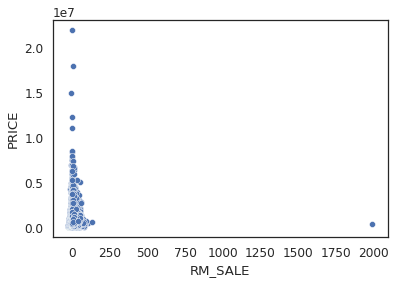

In [ ]:
sns.scatterplot(data=train_df_all,x="RM_SALE",y="PRICE")

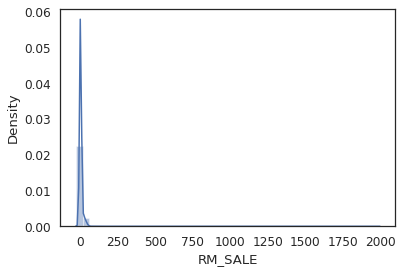

In [ ]:
sns.distplot(train_df_all["RM_SALE"])

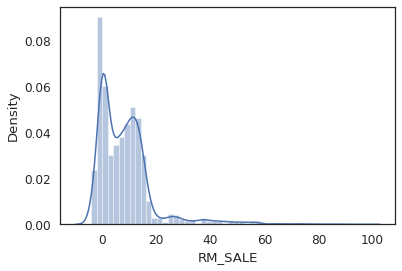

In [ ]:
sns.distplot(test_df_all["RM_SALE"])

In [ ]:

train_df_all['RM_GROUP']  = train_df_all['YR_RMDL'].astype(float)
bins =  [1800] + [i for i in range(1950, 2030, 10)]

labels = []
length = len(bins)-1
for i in range(length):
  label = str(bins[i]) + "-" + str(bins[i+1])
  labels.append(label)

train_df_all['RM_GROUP'] = pd.cut(train_df_all['YR_RMDL'], bins=bins, labels = labels)

test_df_all['RM_GROUP']  = test_df_all['YR_RMDL'].astype(float)
bins =  [1800] + [i for i in range(1950, 2030, 10)]

labels = []
length = len(bins)-1
for i in range(length):
  label = str(bins[i]) + "-" + str(bins[i+1])
  labels.append(label)

test_df_all['RM_GROUP'] = pd.cut(test_df_all['YR_RMDL'], bins=bins, labels = labels)

## AC

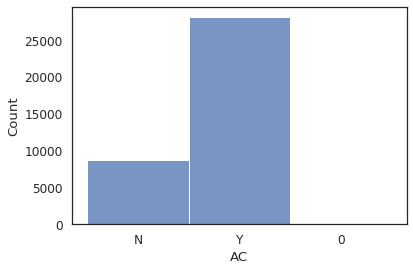

In [ ]:
sns.histplot(train_df_all["AC"])

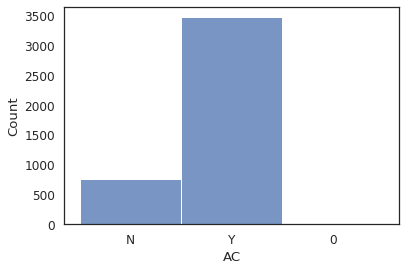

In [ ]:
sns.histplot(test_df_all["AC"])

In [ ]:
#ACのカテゴリー変換
#0はNとして補完
def ac_mod(x):
    if x == 0:
        x="N"
        return x
    elif x == "N":
        x="N"
        return x
    else:
        x="Y"
        return x
    

train_df_all["AC"]=train_df_all["AC"].apply(lambda x: ac_mod(x))
test_df_all["AC"]=test_df_all["AC"].apply(lambda x: ac_mod(x))

## SALEDATE

In [ ]:
#SALE_DATEはYEARに変換
train_df_all["SALEDATE"] = pd.to_datetime(train_df_all["SALEDATE"])
train_df_all["SALEDATE_YEAR"] =train_df_all["SALEDATE"].apply(lambda x : x.year).astype(str)
train_df_all["SALEDATE_MONTH"] =train_df_all["SALEDATE"].apply(lambda x : x.month).astype(float)

#bins = np.arange(1900,2040,20)
#labels = ['1900-1920','1920-1940','1940-1960','1960-1980','1980-2000','2000-2020']
#train_df['SALEDATE_YEAR'] = pd.cut(train_df['SALEDATE_YEAR'], bins, labels = labels)

SALEDATE_MONTH
1.0     537819.736117
2.0     538372.843615
3.0     550015.442475
4.0     571178.374956
5.0     609127.474375
6.0     645560.111956
7.0     658723.624864
8.0     607395.878409
9.0     579309.836240
10.0    576976.922278
11.0    599765.089552
12.0    594156.916178
Name: PRICE, dtype: float64

SALEDATE_MONTH
1.0     2395
2.0     2091
3.0     2651
4.0     2835
5.0     3278
6.0     3814
7.0     3668
8.0     3520
9.0     3096
10.0    3178
11.0    2948
12.0    3412
Name: PRICE, dtype: int64

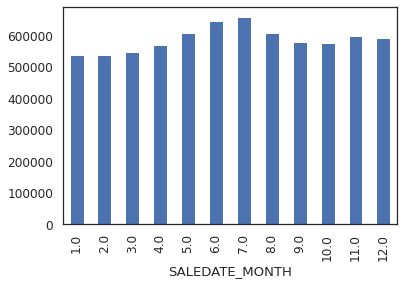

In [ ]:
category("SALEDATE_MONTH",train_df_all)

SALEDATE_YEAR
1982     60000.000000
1985    173000.000000
1986     89000.000000
1990    121750.000000
1991    175000.000000
1992    250033.522604
1993    239887.044503
1994    237320.179337
1995    239896.051653
1996    239464.686090
1997    235183.756063
1998    236363.207196
1999    263375.096267
2000    261142.636520
2001    315390.795506
2002    351147.464578
2003    424948.461985
2004    468102.740216
2005    592007.790470
2006    602241.166778
2007    629362.962252
2008    667421.767279
2009    671761.382005
2010    701530.707577
2011    678932.922527
2012    697022.044085
2013    746639.994508
2014    764644.463907
2015    808967.055988
2016    815633.435883
Name: PRICE, dtype: float64

SALEDATE_YEAR
1982       1
1985       1
1986       1
1990       2
1991       1
1992     553
1993     382
1994     513
1995     484
1996     532
1997     701
1998     806
1999     509
2000    1161
2001    1335
2002    1468
2003    1552
2004    1763
2005    1637
2006    1499
2007    1510
2008    1143
2009    1267
2010    1597
2011    1820
2012    2223
2013    2731
2014    2923
2015    3215
2016    3556
Name: PRICE, dtype: int64

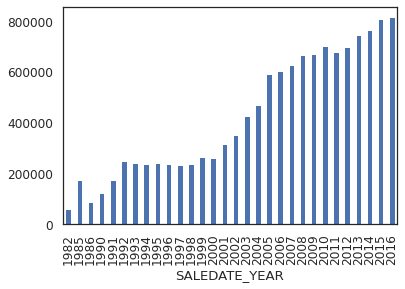

In [ ]:
category("SALEDATE_YEAR",train_df_all)

In [ ]:
train_df_all['SALEDATE_YEAR']  = train_df_all['SALEDATE_YEAR'].astype(float)
#bins =  [1980] + [1995] + [i for i in range(2000, 2025, 5)]
bins =  [i for i in range(2000, 2025, 5)]

labels = []
length = len(bins)-1
for i in range(length):
  label = str(bins[i]) + "-" + str(bins[i+1])
  labels.append(label)

train_df_all['SALEDATE_YEAR_GROUP'] = pd.cut(train_df_all['SALEDATE_YEAR'], bins=bins, labels = labels)


SALEDATE_YEAR
1982.0     60000.000000
1985.0    173000.000000
1986.0     89000.000000
1990.0    121750.000000
1991.0    175000.000000
1992.0    250033.522604
1993.0    239887.044503
1994.0    237320.179337
1995.0    239896.051653
1996.0    239464.686090
1997.0    235183.756063
1998.0    236363.207196
1999.0    263375.096267
2000.0    261142.636520
2001.0    315390.795506
2002.0    351147.464578
2003.0    424948.461985
2004.0    468102.740216
2005.0    592007.790470
2006.0    602241.166778
2007.0    629362.962252
2008.0    667421.767279
2009.0    671761.382005
2010.0    701530.707577
2011.0    678932.922527
2012.0    697022.044085
2013.0    746639.994508
2014.0    764644.463907
2015.0    808967.055988
2016.0    815633.435883
Name: PRICE, dtype: float64

SALEDATE_YEAR
1982.0       1
1985.0       1
1986.0       1
1990.0       2
1991.0       1
1992.0     553
1993.0     382
1994.0     513
1995.0     484
1996.0     532
1997.0     701
1998.0     806
1999.0     509
2000.0    1161
2001.0    1335
2002.0    1468
2003.0    1552
2004.0    1763
2005.0    1637
2006.0    1499
2007.0    1510
2008.0    1143
2009.0    1267
2010.0    1597
2011.0    1820
2012.0    2223
2013.0    2731
2014.0    2923
2015.0    3215
2016.0    3556
Name: PRICE, dtype: int64

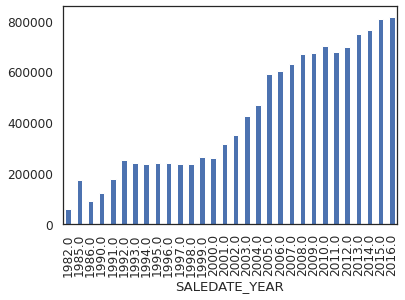

In [ ]:
category("SALEDATE_YEAR",train_df_all)

In [ ]:

#SALE_DATEはYEARに変換
test_df_all["SALEDATE"] = pd.to_datetime(test_df_all["SALEDATE"])
test_df_all["SALEDATE_YEAR"] =test_df_all["SALEDATE"].apply(lambda x : x.year).astype(str)
test_df_all["SALEDATE_MONTH"] =test_df_all["SALEDATE"].apply(lambda x : x.month).astype(float)

#bins = np.arange(1900,2040,20)
#labels = ['1900-1920','1920-1940','1940-1960','1960-1980','1980-2000','2000-2020']
#train_df['SALEDATE_YEAR'] = pd.cut(train_df['SALEDATE_YEAR'], bins, labels = labels)

In [ ]:

test_df_all['SALEDATE_YEAR']  = test_df_all['SALEDATE_YEAR'].astype(float)
#bins =  [1980] + [1995] + [i for i in range(2000, 2025, 5)]
bins =  [i for i in range(2000, 2025, 5)]

labels = []
length = len(bins)-1
for i in range(length):
  label = str(bins[i]) + "-" + str(bins[i+1])
  labels.append(label)

test_df_all['SALEDATE_YEAR_GROUP'] = pd.cut(test_df_all['SALEDATE_YEAR'], bins=bins, labels = labels)

## RATE

In [ ]:
df_rate.index = df_rate["YEAR"]
rates = df_rate.to_dict(orient="dict")["Rate"]

In [ ]:
#計算した築年数別の平均リフォーム年でYR_RMDLを補完
def fill_rate(x):
    x=rates[x]
    return x

train_df_all["RATE"] = train_df_all["SALEDATE_YEAR"]
test_df_all["RATE"] = test_df_all["SALEDATE_YEAR"]
train_df_all["RATE"] = train_df_all["RATE"].apply(lambda x:fill_rate(x)).astype(float)
test_df_all["RATE"] = test_df_all["RATE"].apply(lambda x:fill_rate(x)).astype(float)

In [ ]:
train_df_all.head()

,Id,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,...,ZIPCODE,NATIONALGRID,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT,PRICE,SALEDATE_YEAR,SALEDATE_MONTH,ADDRESS_LOC,BATHRM_ALL,ROOM_ALL,AYB_GROUP,YRRM_AVE,RM_SALE,RM_GROUP,SALEDATE_YEAR_GROUP,RATE
0,0,1,0,Hot Water Rad,N,1.0,6,3,1929.0,2009.296036,1954,2.00,1982-06-11,Q,1,1088.0,1,2 Story,Semi-Detached,Average,Average,Common Brick,Built Up,Hardwood,1.0,...,20012.0,18S UJ 24842 15144,38.967772,-77.021797,15,006 D Brightwood,1901.0,001901 4012,Ward 4,3197,-77.021356,38.967781,NW,60000.0,1982.0,6.0,PLA,1,9,1920-1930,2009.296036,-27.296036,2000-2010,NaN,16.043654
3,3,3,0,Hot Water Rad,N,1.0,6,3,1925.0,2005.296036,1950,2.75,1985-08-05,Q,3,1700.0,1,3 Story,Row Inside,Good Quality,Average,Common Brick,Metal- Sms,Hardwood,1.0,...,20008.0,18S UJ 22127 10659,38.926829,-77.051948,42,None,501.0,000501 1007,Ward 3,2206,-77.051444,38.926412,NW,173000.0,1985.0,8.0,STRE,3,9,1920-1930,2005.296036,-20.296036,2000-2010,NaN,12.430192
5,5,1,2,Warm Cool,Y,1.0,6,3,1977.0,1985.000000,1983,3.00,1986-12-02,Q,1,1870.0,1,3 Story,Row End,Average,Average,Shingle,Shake,Hardwood,1.0,...,20020.0,18S UJ 28470 04560,38.873170,-76.977293,4,002 B Anacostia,7601.0,007601 1004,Ward 8,5565,-76.976512,38.872954,SE,89000.0,1986.0,12.0,STRE,3,9,1970-1980,2006.652482,1.000000,1980-1990,NaN,10.187308
9,9,2,1,Warm Cool,Y,1.0,7,3,1974.0,2003.652482,1982,2.00,1990-08-20,Q,2,1240.0,1,2 Story,Semi-Detached,Above Average,Average,Brick/Siding,Comp Shingle,Carpet,1.0,...,20017.0,18S UJ 26916 12794,38.947019,-76.997273,18,007 B Brookland,9509.0,009509 3004,Ward 5,3796,-76.998072,38.947143,NE,116500.0,1990.0,8.0,RO,3,10,1970-1980,2003.652482,-13.652482,2000-2010,NaN,10.129423
11,11,2,1,Warm Cool,Y,1.0,7,3,1974.0,2003.652482,1982,2.00,1990-12-12,Q,3,1240.0,1,2 Story,Semi-Detached,Above Average,Average,Brick/Siding,Comp Shingle,Carpet,1.0,...,20017.0,18S UJ 26918 12874,38.947743,-76.997277,18,007 B Brookland,9509.0,009509 3004,Ward 5,3796,-76.998072,38.947143,NE,127000.0,1990.0,12.0,STRE,3,10,1970-1980,2003.652482,-13.652482,2000-2010,NaN,10.129423


In [ ]:
train_df_all["RATE"].isnull().sum()

0

[(0.0, 12000000.0)]

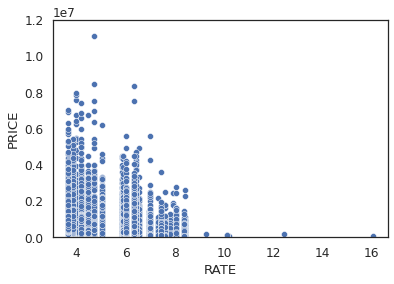

In [ ]:
g=sns.scatterplot(data=train_df_all,x="RATE",y="PRICE")
g.set(ylim=(0,12000000))

## QUADRANT

QUADRANT
NE    410288.853355
NW    784357.900027
SE    383401.589327
SW    356135.581560
Name: PRICE, dtype: float64

QUADRANT
NE    10863
NW    18705
SE     6840
SW      423
Name: PRICE, dtype: int64

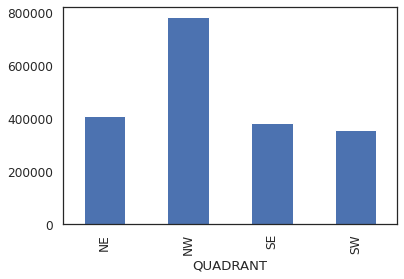

In [ ]:
#QUADRANT 欠損値補完
#QUADRANT NAはここでは最頻値で補完。後ほどLocationの情報をもとに補完。
category("QUADRANT",train_df_all)

In [ ]:
train_df_all["QUADRANT"].mode()[0]

'NW'

In [ ]:
train_df_all["QUADRANT"] = train_df_all["QUADRANT"].replace(np.nan,str(train_df_all["QUADRANT"].mode()[0]))
test_df_all["QUADRANT"] = test_df_all["QUADRANT"].replace(np.nan,str(test_df_all["QUADRANT"].mode()[0]))

In [ ]:
train_df_all["QUADRANT"].unique()

array(['NW', 'SE', 'NE', 'SW'], dtype=object)

QUADRANT_N
1    356135.581560
2    383401.589327
3    410288.853355
4    783410.562313
Name: PRICE, dtype: float64

QUADRANT_N
1      423
2     6840
3    10863
4    18760
Name: PRICE, dtype: int64

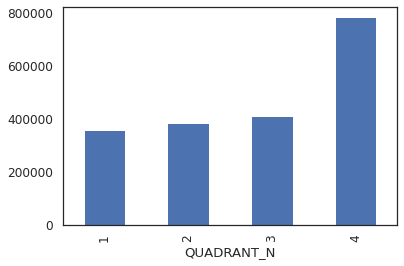

In [ ]:
def q_rank(x):
        
    if x == "NW":
        x= 4
        return x
    elif x=="NE":
        x= 3
        return x
    elif x == "SE":
        x=2
        return x
    elif x == "SW":
        x=1
        return x

train_df_all["QUADRANT_N"] = train_df_all["QUADRANT"].apply(lambda x : q_rank(x))
test_df_all["QUADRANT_N"] = test_df_all["QUADRANT"].apply(lambda x : q_rank(x))
category("QUADRANT_N",train_df_all)

## CNDTN

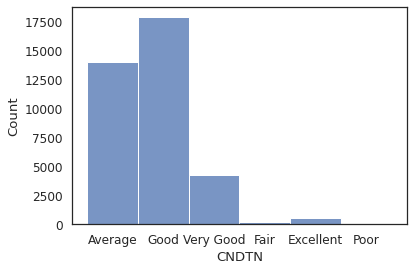

In [ ]:
sns.histplot(train_df_all["CNDTN"])

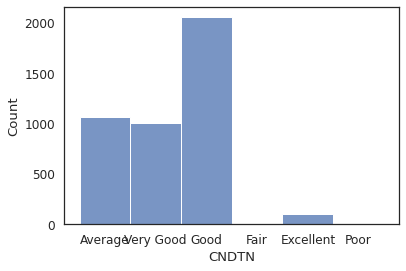

In [ ]:
sns.histplot(test_df_all["CNDTN"])

CNDTN
Average      3.799113e+05
Excellent    1.302705e+06
Fair         3.415078e+05
Good         6.623542e+05
Poor         3.192295e+05
Very Good    9.413615e+05
Name: PRICE, dtype: float64

CNDTN
Average      14004
Excellent      501
Fair           186
Good         17885
Poor            21
Very Good     4289
Name: PRICE, dtype: int64

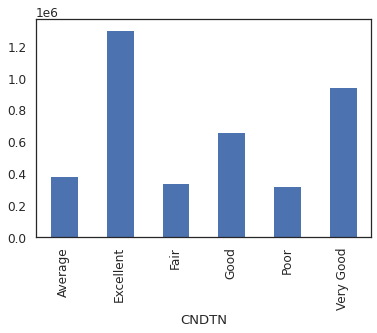

In [ ]:
#CNDTNの欠損値補完
category("CNDTN",train_df_all)

In [ ]:
train_df_all = train_df_all.copy()
train_df_all = train_df_all[train_df_all["CNDTN"]!="Default"]

In [ ]:
train_df_all.groupby("CNDTN").AYB.apply(lambda x:x.mean())

CNDTN
Average      1930.521351
Excellent    1999.037924
Fair         1924.860215
Good         1930.943025
Poor         1923.142857
Very Good    1949.645139
Name: AYB, dtype: float64

In [ ]:
def cnd_label(x):
  if x == "Excellent":
    x= 6
    return x
  elif x=="Very Good":
    x= 5
    return x
  elif x == "Good":
    x=4
    return x
  elif x == "Fair":
    x=3
    return x
  elif x == "Average":
    x=2
    return x
  elif x == "Fair":
    x=1
    return x
  elif x == "Poor":
    x=0
    return x

In [ ]:
train_df_all["CNDTN"] = train_df_all["CNDTN"].apply(lambda x : cnd_label(x))
test_df_all["CNDTN"] = test_df_all["CNDTN"].apply(lambda x : cnd_label(x))

CNDTN
0    3.192295e+05
2    3.799113e+05
3    3.415078e+05
4    6.623542e+05
5    9.413615e+05
6    1.302705e+06
Name: PRICE, dtype: float64

CNDTN
0       21
2    14004
3      186
4    17885
5     4289
6      501
Name: PRICE, dtype: int64

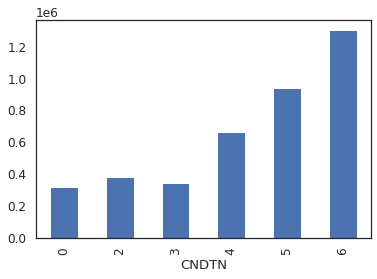

In [ ]:
category("CNDTN",train_df_all)

In [ ]:
train_df_all["CNDTN"].isnull().sum()

0

## LOCATION

In [ ]:
#loc_df = pd.read_csv("./data/raw_address_points.csv", sep=",", header=0, quotechar="\"")
#loc_df.head()

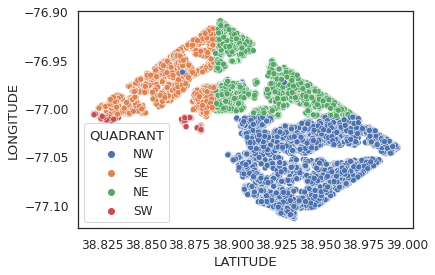

In [ ]:
sns.scatterplot(data = train_df_all, x=train_df_all["LATITUDE"] ,y=train_df_all["LONGITUDE"], hue="QUADRANT")

In [ ]:
#train_df_all = train_df_all.copy()
#temp_df = train_df_all[train_df_all["PRICE"] < 1000000]
temp_df = train_df_all.copy()

In [ ]:
temp_df["LATITUDE"].describe()

count    36886.000000
mean        38.918145
std          0.033211
min         38.819953
25%         38.894601
50%         38.918867
75%         38.944344
max         38.994894
Name: LATITUDE, dtype: float64

In [ ]:
temp_df["LATITUDE"]  = temp_df["LATITUDE"].astype(float)
bins =  np.arange(38.80, 39.00, 0.005)

labels = []
length = len(bins)-1
for i in range(length):
  label = str(round((bins[i] + bins[i+1])/2,4))
  labels.append(label)

temp_df["LATITUDE_GROUP"] = pd.cut(temp_df["LATITUDE"], bins=bins, labels = labels)

In [ ]:
temp_df["LATITUDE_GROUP"] = temp_df["LATITUDE_GROUP"].replace(np.nan,0)

In [ ]:
temp_df["LONGITUDE"].describe()

count    36886.000000
mean       -77.014334
std          0.043039
min        -77.113909
25%        -77.042081
50%        -77.011340
75%        -76.986297
max        -76.909758
Name: LONGITUDE, dtype: float64

In [ ]:
temp_df["LONGITUDE"]  = temp_df["LONGITUDE"].astype(float)
bins =  np.arange(-77.10, -76.89, 0.005)

labels = []
length = len(bins)-1
for i in range(length):
  label = str(round((bins[i] + bins[i+1])/2,4))
  labels.append(label)

temp_df["LONGITUDE_GROUP"] = pd.cut(temp_df["LONGITUDE"], bins=bins, labels = labels)

In [ ]:
temp_df

,Id,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,...,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT,PRICE,SALEDATE_YEAR,SALEDATE_MONTH,ADDRESS_LOC,BATHRM_ALL,ROOM_ALL,AYB_GROUP,YRRM_AVE,RM_SALE,RM_GROUP,SALEDATE_YEAR_GROUP,RATE,QUADRANT_N,LATITUDE_GROUP,LONGITUDE_GROUP
0,0,1,0,Hot Water Rad,N,1.0,6,3,1929.0,2009.296036,1954,2.00,1982-06-11,Q,1,1088.0,1,2 Story,Semi-Detached,Average,2,Common Brick,Built Up,Hardwood,1.0,...,-77.021797,15,006 D Brightwood,1901.0,001901 4012,Ward 4,3197,-77.021356,38.967781,NW,60000.0,1982.0,6.0,PLA,1,9,1920-1930,2009.296036,-27.296036,2000-2010,NaN,16.043654,4,38.9675,-77.0225
3,3,3,0,Hot Water Rad,N,1.0,6,3,1925.0,2005.296036,1950,2.75,1985-08-05,Q,3,1700.0,1,3 Story,Row Inside,Good Quality,2,Common Brick,Metal- Sms,Hardwood,1.0,...,-77.051948,42,None,501.0,000501 1007,Ward 3,2206,-77.051444,38.926412,NW,173000.0,1985.0,8.0,STRE,3,9,1920-1930,2005.296036,-20.296036,2000-2010,NaN,12.430192,4,38.9275,-77.0525
5,5,1,2,Warm Cool,Y,1.0,6,3,1977.0,1985.000000,1983,3.00,1986-12-02,Q,1,1870.0,1,3 Story,Row End,Average,2,Shingle,Shake,Hardwood,1.0,...,-76.977293,4,002 B Anacostia,7601.0,007601 1004,Ward 8,5565,-76.976512,38.872954,SE,89000.0,1986.0,12.0,STRE,3,9,1970-1980,2006.652482,1.000000,1980-1990,NaN,10.187308,2,38.8725,-76.9775
9,9,2,1,Warm Cool,Y,1.0,7,3,1974.0,2003.652482,1982,2.00,1990-08-20,Q,2,1240.0,1,2 Story,Semi-Detached,Above Average,2,Brick/Siding,Comp Shingle,Carpet,1.0,...,-76.997273,18,007 B Brookland,9509.0,009509 3004,Ward 5,3796,-76.998072,38.947143,NE,116500.0,1990.0,8.0,RO,3,10,1970-1980,2003.652482,-13.652482,2000-2010,NaN,10.129423,3,38.9475,-76.9975
11,11,2,1,Warm Cool,Y,1.0,7,3,1974.0,2003.652482,1982,2.00,1990-12-12,Q,3,1240.0,1,2 Story,Semi-Detached,Above Average,2,Brick/Siding,Comp Shingle,Carpet,1.0,...,-76.997277,18,007 B Brookland,9509.0,009509 3004,Ward 5,3796,-76.998072,38.947143,NE,127000.0,1990.0,12.0,STRE,3,10,1970-1980,2003.652482,-13.652482,2000-2010,NaN,10.129423,3,38.9475,-76.9975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82639,82639,2,0,Hot Water Rad,Y,1.0,6,3,1928.0,2004.000000,1964,2.00,2016-12-30,Q,4,1106.0,1,2 Story,Single,Average,4,Wood Siding,Comp Shingle,Hardwood,1.0,...,-76.971257,12,056 A Woodridge,9400.0,009400 3018,Ward 5,4292,-76.971260,38.933607,NE,535000.0,2016.0,12.0,0,2,9,1920-1930,2008.296036,12.000000,2000-2010,2015-2020,3.654038,3,38.9325,-76.9725
82640,82640,1,2,Hot Water Rad,Y,1.0,7,3,1927.0,2011.000000,1982,2.00,2016-12-30,Q,3,1508.0,1,2 Story,Row Inside,Good Quality,4,Stone,Metal- Sms,Hardwood,1.0,...,-77.040346,36,036 B Mt. Pleasant,2702.0,002702 2004,Ward 1,2588,-77.041043,38.928171,NW,937000.0,2016.0,12.0,0,3,10,1920-1930,2007.296036,5.000000,2010-2020,2015-2020,3.654038,4,38.9275,-77.0425
82641,82641,2,1,Forced Air,Y,1.0,7,3,1955.0,2016.000000,1973,2.00,2016-12-30,Q,3,1346.0,1,2 Story,Semi-Detached,Average,4,Common Brick,Built Up,Carpet,1.0,...,-76.991292,9,None,9508.0,009508 2004,Ward 5,3752,-76.990900,38.955086,NE,475000.0,2016.0,12.0,0,3,10,1950-1960,2006.410200,0.000000,2010-2020,2015-2020,3.654038,3,38.9575,-76.9925
82648,82648,2,1,Forced Air,Y,1.0,8,3,1927.0,2012.000000,1964,2.00,2016-12-30,Q,5,1056.0,1,2 Story,Row Inside,Average,5,Common Brick,Metal- Sms,Hardwood,1.0,...,-77.022357,16,042 B Petworth,2101.0,002101 3005,Ward 4,3149,-77.022995,38.952523,NW,599900.0,2016.0,12.0,0,3,11,1920-1930,2007.296036,4.000000,2010-2020,2015-2020,3.654038,4,38.9525,-77.0225


In [ ]:
temp_df_2 = temp_df.groupby(["LONGITUDE_GROUP","LATITUDE_GROUP","QUADRANT"]).PRICE.agg(["mean","count"]).reset_index()
temp_df_2["LONGITUDE_GROUP"] = temp_df_2["LONGITUDE_GROUP"].astype(float)
temp_df_2["LATITUDE_GROUP"] = temp_df_2["LATITUDE_GROUP"].astype(float)
temp_df_fol=temp_df_2.query("count > 10").reset_index(drop=True)


In [ ]:
temp_df_fol

,LONGITUDE_GROUP,LATITUDE_GROUP,QUADRANT,mean,count
0,-77.0975,38.9175,NW,9.165219e+05,65
1,-77.0975,38.9225,NW,1.217776e+06,57
2,-77.0975,38.9275,NW,1.590689e+06,37
3,-77.0975,38.9325,NW,2.114059e+06,46
4,-77.0975,38.9375,NW,1.805661e+06,55
...,...,...,...,...,...
473,-76.9175,38.8875,SE,3.307450e+05,56
474,-76.9175,38.8925,NE,2.235135e+05,64
475,-76.9175,38.8975,NE,2.333588e+05,71
476,-76.9125,38.8925,NE,1.914845e+05,46


In [ ]:

def map_scaling(df):
    
    base_amount = min(df["mean"])

    # 円の大きさの倍率
    scale = 40

    # 地図の定義
    map = folium.Map(location=[38.9, -77], zoom_start=12)

    # 販売量を円の大きさで表す
    for index, row in df.iterrows():
        location = (row["LATITUDE_GROUP"], row["LONGITUDE_GROUP"])   # 座標
        radius = scale * (row["mean"] / base_amount) # 円の大きさ
        # 円を地図に追加
        folium.Circle(location=location,      # 地点の緯度経度
                    radius=radius,          # 円の大きさ
                    color="darkblue",       # 円の色
                    fill_color="darkblue",  # 円内の色
                    popup=str(row["count"])       # マウスオーバー時の表示項目
        ).add_to(map)
    return map

map_scaling(temp_df_fol)

In [ ]:
temp_df_fol_NW =temp_df_fol[temp_df_fol["QUADRANT"]=="NW"]
#map_scaling(temp_df_fol_NW)

In [ ]:
temp_df_fol_SE =temp_df_fol[temp_df_fol["QUADRANT"]=="SE"]
#map_scaling(temp_df_fol_SE)

In [ ]:
temp_df_fol_NE =temp_df_fol[temp_df_fol["QUADRANT"]=="NE"]
#map_scaling(temp_df_fol_NE)

In [ ]:
temp_df_fol_SW =temp_df_fol[temp_df_fol["QUADRANT"]=="SW"]
#map_scaling(temp_df_fol_SW)

In [ ]:
all_loc = temp_df_fol.iloc[temp_df_fol["mean"].sort_values(ascending=False).index[0]]
all_loc_NW = temp_df_fol.iloc[temp_df_fol_NW["mean"].sort_values(ascending=False).index[0]]
all_loc_NE = temp_df_fol.iloc[temp_df_fol_NE["mean"].sort_values(ascending=False).index[0]]
all_loc_SE = temp_df_fol.iloc[temp_df_fol_SE["mean"].sort_values(ascending=False).index[0]]
all_loc_SW = temp_df_fol.iloc[temp_df_fol_SW["mean"].sort_values(ascending=False).index[0]]

In [ ]:
#base_long = -77.048
#base_lat = 38.9184
base_long = all_loc.LONGITUDE_GROUP
base_lat = all_loc.LATITUDE_GROUP
base_long_NW = all_loc_NW.LONGITUDE_GROUP
base_lat_NW = all_loc_NW.LATITUDE_GROUP
base_long_NE = all_loc_NE.LONGITUDE_GROUP
base_lat_NE = all_loc_NE.LATITUDE_GROUP
base_long_SE = all_loc_SE.LONGITUDE_GROUP
base_lat_SE = all_loc_SE.LATITUDE_GROUP
base_long_SW = all_loc_SW.LONGITUDE_GROUP
base_lat_SW = all_loc_SW.LATITUDE_GROUP

In [ ]:
train_df_all.head()

,Id,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,...,NATIONALGRID,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT,PRICE,SALEDATE_YEAR,SALEDATE_MONTH,ADDRESS_LOC,BATHRM_ALL,ROOM_ALL,AYB_GROUP,YRRM_AVE,RM_SALE,RM_GROUP,SALEDATE_YEAR_GROUP,RATE,QUADRANT_N
0,0,1,0,Hot Water Rad,N,1.0,6,3,1929.0,2009.296036,1954,2.00,1982-06-11,Q,1,1088.0,1,2 Story,Semi-Detached,Average,2,Common Brick,Built Up,Hardwood,1.0,...,18S UJ 24842 15144,38.967772,-77.021797,15,006 D Brightwood,1901.0,001901 4012,Ward 4,3197,-77.021356,38.967781,NW,60000.0,1982.0,6.0,PLA,1,9,1920-1930,2009.296036,-27.296036,2000-2010,NaN,16.043654,4
3,3,3,0,Hot Water Rad,N,1.0,6,3,1925.0,2005.296036,1950,2.75,1985-08-05,Q,3,1700.0,1,3 Story,Row Inside,Good Quality,2,Common Brick,Metal- Sms,Hardwood,1.0,...,18S UJ 22127 10659,38.926829,-77.051948,42,None,501.0,000501 1007,Ward 3,2206,-77.051444,38.926412,NW,173000.0,1985.0,8.0,STRE,3,9,1920-1930,2005.296036,-20.296036,2000-2010,NaN,12.430192,4
5,5,1,2,Warm Cool,Y,1.0,6,3,1977.0,1985.000000,1983,3.00,1986-12-02,Q,1,1870.0,1,3 Story,Row End,Average,2,Shingle,Shake,Hardwood,1.0,...,18S UJ 28470 04560,38.873170,-76.977293,4,002 B Anacostia,7601.0,007601 1004,Ward 8,5565,-76.976512,38.872954,SE,89000.0,1986.0,12.0,STRE,3,9,1970-1980,2006.652482,1.000000,1980-1990,NaN,10.187308,2
9,9,2,1,Warm Cool,Y,1.0,7,3,1974.0,2003.652482,1982,2.00,1990-08-20,Q,2,1240.0,1,2 Story,Semi-Detached,Above Average,2,Brick/Siding,Comp Shingle,Carpet,1.0,...,18S UJ 26916 12794,38.947019,-76.997273,18,007 B Brookland,9509.0,009509 3004,Ward 5,3796,-76.998072,38.947143,NE,116500.0,1990.0,8.0,RO,3,10,1970-1980,2003.652482,-13.652482,2000-2010,NaN,10.129423,3
11,11,2,1,Warm Cool,Y,1.0,7,3,1974.0,2003.652482,1982,2.00,1990-12-12,Q,3,1240.0,1,2 Story,Semi-Detached,Above Average,2,Brick/Siding,Comp Shingle,Carpet,1.0,...,18S UJ 26918 12874,38.947743,-76.997277,18,007 B Brookland,9509.0,009509 3004,Ward 5,3796,-76.998072,38.947143,NE,127000.0,1990.0,12.0,STRE,3,10,1970-1980,2003.652482,-13.652482,2000-2010,NaN,10.129423,3


In [ ]:
from geopy.distance import geodesic

def calculate_distance(row):
    base_point=(base_lat,base_long)
    actual_point = (row["LATITUDE"],row["LONGITUDE"])
    dis = geodesic(base_point, actual_point).km
    return dis

train_df_all["DISTANCE"] =train_df_all.apply(calculate_distance,axis=1)
test_df_all["DISTANCE"] =test_df_all.apply(calculate_distance,axis=1)
    

In [ ]:

def calculate_distance(row):
    if row["QUADRANT"]=="NW":    
        base_point=(base_lat_NW,base_long_NW)
        actual_point = (row["LATITUDE"],row["LONGITUDE"])
        dis = geodesic(base_point, actual_point).km
        return dis
    elif row["QUADRANT"]=="NE":    
        base_point=(base_lat_NE,base_long_NE)
        actual_point = (row["LATITUDE"],row["LONGITUDE"])
        dis = geodesic(base_point, actual_point).km
        return dis
    elif row["QUADRANT"]=="SE":    
        base_point=(base_lat_SE,base_long_SE)
        actual_point = (row["LATITUDE"],row["LONGITUDE"])
        dis = geodesic(base_point, actual_point).km
        return dis
    elif row["QUADRANT"]=="SW":    
        base_point=(base_lat_SW,base_long_SW)
        actual_point = (row["LATITUDE"],row["LONGITUDE"])
        dis = geodesic(base_point, actual_point).km
        return dis
    

train_df_all["DISTANCE_LOC"] =train_df_all.apply(calculate_distance,axis=1)
test_df_all["DISTANCE_LOC"] =test_df_all.apply(calculate_distance,axis=1)
    

[(0.0, 12000000.0)]

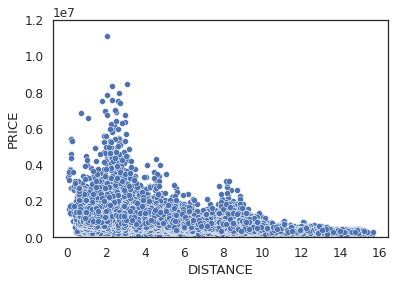

In [ ]:
g=sns.scatterplot(data=train_df_all,x="DISTANCE",y="PRICE")
g.set(ylim=(0,12000000))

[(0.0, 12000000.0)]

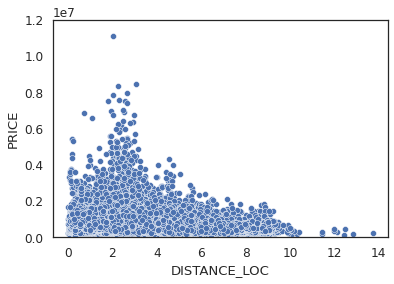

In [ ]:
g=sns.scatterplot(data=train_df_all,x="DISTANCE_LOC",y="PRICE")
g.set(ylim=(0,12000000))

In [ ]:

def calculate_distance_un(row):
    base_point=(38.897934509235164, -77.00632784219272)
    actual_point = (row["LATITUDE"],row["LONGITUDE"])
    dis = geodesic(base_point, actual_point).km
    return dis

train_df_all["DISTANCE_UN"] =train_df_all.apply(calculate_distance_un,axis=1)
test_df_all["DISTANCE_UN"] =test_df_all.apply(calculate_distance_un,axis=1)

[(0.0, 12000000.0)]

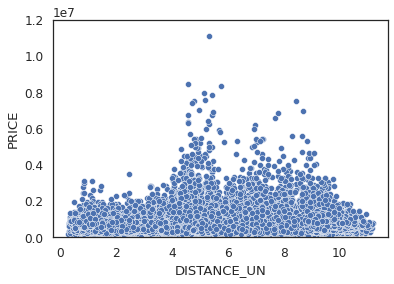

In [ ]:
g=sns.scatterplot(data=train_df_all,x="DISTANCE_UN",y="PRICE")
g.set(ylim=(0,12000000))

In [ ]:

def calculate_distance_gp(row):
    base_point=(38.899750137552566, -77.0216272511553)
    actual_point = (row["LATITUDE"],row["LONGITUDE"])
    dis = geodesic(base_point, actual_point).km
    return dis

train_df_all["DISTANCE_GP"] =train_df_all.apply(calculate_distance_gp,axis=1)
test_df_all["DISTANCE_GP"] =test_df_all.apply(calculate_distance_gp,axis=1)

In [ ]:
g=sns.scatterplot(data=train_df_all,x="DISTANCE_GP",y="PRICE")
g.set(ylim=(0,12000000))

In [ ]:

def calculate_distance_fn(row):
    base_point=(38.90377704321304, -77.04029063713435)
    actual_point = (row["LATITUDE"],row["LONGITUDE"])
    dis = geodesic(base_point, actual_point).km
    return dis

train_df_all["DISTANCE_FN"] =train_df_all.apply(calculate_distance_fn,axis=1)
test_df_all["DISTANCE_FN"] =test_df_all.apply(calculate_distance_fn,axis=1)

In [ ]:
g=sns.scatterplot(data=train_df_all,x="DISTANCE_FN",y="PRICE")
g.set(ylim=(0,12000000))

In [ ]:

def calculate_distance_mc(row):
    base_point=(38.898481668057094, -77.02933625251192)
    actual_point = (row["LATITUDE"],row["LONGITUDE"])
    dis = geodesic(base_point, actual_point).km
    return dis

train_df_all["DISTANCE_MC"] =train_df_all.apply(calculate_distance_mc,axis=1)
test_df_all["DISTANCE_MC"] =test_df_all.apply(calculate_distance_mc,axis=1)

[(0.0, 12000000.0)]

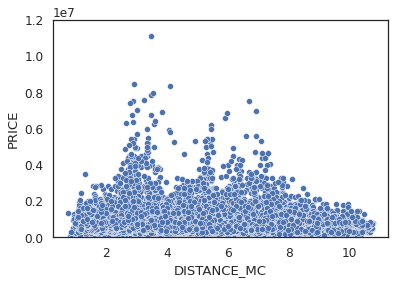

In [ ]:
g=sns.scatterplot(data=train_df_all,x="DISTANCE_MC",y="PRICE")
g.set(ylim=(0,12000000))

In [ ]:

def calculate_distance_fw(row):
    base_point=(38.90129653257092, -77.03991436428784)
    actual_point = (row["LATITUDE"],row["LONGITUDE"])
    dis = geodesic(base_point, actual_point).km
    return dis

train_df_all["DISTANCE_FW"] =train_df_all.apply(calculate_distance_fw,axis=1)
test_df_all["DISTANCE_FW"] =test_df_all.apply(calculate_distance_fw,axis=1)

In [ ]:
g=sns.scatterplot(data=train_df_all,x="DISTANCE_FW",y="PRICE")
g.set(ylim=(0,12000000))

In [ ]:

def calculate_distance_fb(row):
    base_point=(38.90105634874659, -77.05043913661183)
    actual_point = (row["LATITUDE"],row["LONGITUDE"])
    dis = geodesic(base_point, actual_point).km
    return dis

train_df_all["DISTANCE_FB"] =train_df_all.apply(calculate_distance_fb,axis=1)
test_df_all["DISTANCE_FB"] =test_df_all.apply(calculate_distance_fb,axis=1)

In [ ]:
g=sns.scatterplot(data=train_df_all,x="DISTANCE_FB",y="PRICE")
g.set(ylim=(0,12000000))

In [ ]:

def calculate_distance_dc(row):
    base_point=(38.908746945244246,-77.04330696860683)
    actual_point = (row["LATITUDE"],row["LONGITUDE"])
    dis = geodesic(base_point, actual_point).km
    return dis

train_df_all["DISTANCE_DC"] =train_df_all.apply(calculate_distance_dc,axis=1)
test_df_all["DISTANCE_DC"] =test_df_all.apply(calculate_distance_dc,axis=1)

In [ ]:
g=sns.scatterplot(data=train_df_all,x="DISTANCE_DC",y="PRICE")
g.set(ylim=(0,12000000))

## GBA

In [ ]:
g=sns.scatterplot(data=train_df_all,x="GBA",y="PRICE")
g.set(ylim=(0,12000000))

In [ ]:
train_df_all["Wide"] = train_df_all["LANDAREA"] - train_df_all["GBA"]
test_df_all["Wide"] = test_df_all["LANDAREA"] - test_df_all["GBA"]

In [ ]:
(train_df_all["Wide"] < 0).sum()

In [ ]:
(train_df_all["Wide"] > 0).sum()

In [ ]:
train_df_all = train_df_all[train_df_all["Wide"] <75000]

In [ ]:
g=sns.scatterplot(data=train_df_all,x="Wide",y="PRICE")
g.set(ylim=(0,12000000))

## GBA/LANDAREA

In [ ]:
train_df_all["LANDAREA"].mask(train_df_all["LANDAREA"] ==0, train_df_all["GBA"],  inplace=True)
test_df_all["LANDAREA"].mask(test_df_all["LANDAREA"] ==0, test_df_all["GBA"],  inplace=True)

In [ ]:
train_df_all["BL_RATIO"] = train_df_all["GBA"]/train_df_all["LANDAREA"]
test_df_all["BL_RATIO"] = test_df_all["GBA"]/test_df_all["LANDAREA"]

In [ ]:
g=sns.scatterplot(data=train_df_all,x="BL_RATIO",y="PRICE")
g.set(ylim=(0,12000000))

In [ ]:
(train_df_all["LANDAREA"] == 0).sum()

In [ ]:
(test_df_all["LANDAREA"] == 0).sum()

## Distance with nexthouse

In [ ]:
train_df_all.columns

In [ ]:
temp_1 = train_df_all.sort_values(['LATITUDE','LONGITUDE'],ascending=[False,True])
temp_1 = temp_1[["Id","LATITUDE",'LONGITUDE']].reset_index(drop=True)
temp_1

In [ ]:
temp_1t = test_df_all.sort_values(['LATITUDE','LONGITUDE'],ascending=[False,True])
temp_1t = temp_1t[["Id","LATITUDE",'LONGITUDE']].reset_index(drop=True)
temp_1t

In [ ]:
a = temp_1.copy()
a = a[49413:]
a

In [ ]:
b = temp_1t.copy()
b = b[4246:]
b

In [ ]:
temp_2 = temp_1[1:].reset_index(drop=True)
temp_2 = pd.concat([temp_2,a],axis=0).reset_index(drop=True)
temp_2["Id"] = temp_1["Id"]
temp_2

In [ ]:
temp_2t = temp_1t[1:].reset_index(drop=True)
temp_2t = pd.concat([temp_2t,b],axis=0).reset_index(drop=True)
temp_2t["Id"] = temp_1t["Id"]
temp_2t

In [ ]:
def calculate_distance_next(row):
    base_point=(row["LATITUDE_x"],row["LONGITUDE_x"])
    actual_point = (row["LATITUDE_y"],row["LONGITUDE_y"])
    dis = geodesic(base_point, actual_point).km
    return dis

In [ ]:
temp_3 = temp_1.merge(temp_2,on="Id")
temp_3["NEXT_DIS"] = temp_3.apply(calculate_distance_next,axis=1)
temp_3

In [ ]:
temp_3t = temp_1t.merge(temp_2t,on="Id")
temp_3t["NEXT_DIS"] = temp_3t.apply(calculate_distance_next,axis=1)
temp_3t

In [ ]:
train_df_all = train_df_all.merge(temp_3[["Id","NEXT_DIS"]],on="Id")
test_df_all = test_df_all.merge(temp_3t[["Id","NEXT_DIS"]],on="Id")
g=sns.scatterplot(data=train_df_all,x="NEXT_DIS",y="PRICE")
g.set(ylim=(0,12000000))

## SALE_NUM

In [ ]:
category("SALE_NUM",train_df_all)

In [ ]:
train_df_all["SALE_YEAR"] =train_df_all["SALEDATE"].apply(lambda x : x.year).astype(float)
train_df_all["SALE_MONTH"] =train_df_all["SALEDATE"].apply(lambda x : x.month).astype(float)
test_df_all["SALE_YEAR"] =test_df_all["SALEDATE"].apply(lambda x : x.year).astype(float)
test_df_all["SALE_MONTH"] =test_df_all["SALEDATE"].apply(lambda x : x.month).astype(float)

In [ ]:
train_df_all["BULD_AGE"] = 2016 - train_df_all["AYB"]
test_df_all["BULD_AGE"] = 2016 - test_df_all["AYB"]
#train_df_all["BULD_AGE"] = train_df_all["SALE_YEAR"] - train_df_all["AYB"]
#test_df_all["BULD_AGE"] = train_df_all["SALE_YEAR"] - test_df_all["AYB"]

In [ ]:
sns.scatterplot(data=train_df_all,x="BULD_AGE",y="PRICE")

In [ ]:
train_df_all = train_df_all.copy()
train_df_all = train_df_all[train_df_all["BULD_AGE"] > 0]
train_df_all["LIV_DUR"] = train_df_all["BULD_AGE"] / train_df_all["SALE_NUM"]

test_df_all = test_df_all.copy()
#test_df_all = test_df_all[test_df_all["LIV_DUR"] > 0]
test_df_all["LIV_DUR"] = test_df_all["BULD_AGE"] / test_df_all["SALE_NUM"]

In [ ]:
g=sns.scatterplot(data=train_df_all,x="LIV_DUR",y="PRICE")
g.set(ylim=(0,12000000))

## GRADE

In [ ]:
category("GRADE",train_df_all)

In [ ]:
fig, ax = plt.subplots(figsize = (4,4)) 

sns.histplot(test_df_all["GRADE"])
labels = ax.get_xticklabels() 
plt.setp(labels, rotation=90);

In [ ]:
train_df_all["GRADE"].isnull().sum()

In [ ]:
train_df_all["GRADE"].unique()

In [ ]:
def grade_label(x):
  if x == 'Exceptional-C':
    x= 11
    return x
  elif x=='Exceptional-D':
    x= 10
    return x
  elif x == 'Exceptional-B':
    x=9
    return x
  elif x == 'Exceptional-A':
    x=8
    return x
  elif x == "Superior":
    x=7
    return x
  elif x == "Excellent":
    x= 6
    return x
  elif x=="Very Good":
    x= 5
    return x
  elif x == 'Good Quality':
    x=4
    return x
  elif x == 'Above Average':
    x=3
    return x
  elif x == "Average":
    x=2
    return x
  elif x == 'Fair Quality':
    x=1
    return x
  elif x == 'Low Quality':
    x=0
    return x

In [ ]:
train_df_all["GRADE"] = train_df_all["GRADE"].apply(lambda x : grade_label(x))
test_df_all["GRADE"] = test_df_all["GRADE"].apply(lambda x : grade_label(x))

In [ ]:
category("GRADE",train_df_all)

In [ ]:
train_df_all["GRADE"].isnull().sum()

## WARD

In [ ]:
category("WARD",train_df_all)

## LAND AREA

In [ ]:
train_df_all.columns

In [ ]:
g=sns.scatterplot(data=train_df_all,x="LANDAREA",y="PRICE")
g.set(ylim=(0,12000000))

## GBA/ROOMS

In [ ]:
train_df_all["ROOM_AREA"] = train_df_all["GBA"]/(train_df_all["ROOM_ALL"]+1)
test_df_all["ROOM_AREA"] = test_df_all["GBA"]/(test_df_all["ROOM_ALL"]+1)

## SUMMARY

In [ ]:
test_df_all.columns

In [ ]:
train_df_all.columns

In [ ]:
feature_list =['QUADRANT_N',
               "ASSESSMENT_NBHD",
               "ROOM_AREA",
               #"STREET_TYPE",
               #"RATE",
               #"KITCHENS",
               "BULD_AGE",
               "FIREPLACES",
               "LIV_DUR",
               'LANDAREA',
               'SALEDATE_YEAR',
               #'SALEDATE_MONTH',
               "BL_RATIO",
               #'SALEDATE_YEAR_GROUP',
               'BATHRM_ALL',
               'ROOM_ALL',
               #'AYB_GROUP',
               "YR_RMDL",
               "AYB",
               "EYB",
               #'RM_GROUP', 
               "RM_SALE",
               'GBA',
               'AC', 
               'CNDTN', 
               #'DISTANCE',
               "DISTANCE_LOC",'DISTANCE_UN', 'DISTANCE_GP', 'DISTANCE_FN','DISTANCE_MC', 'DISTANCE_FW', 'DISTANCE_FB', 'DISTANCE_DC',
               #"NEXT_DIS",
               "WARD",
               "GRADE",
               "USECODE",
               "STORIES",
               #"ZIPCODE",
               #"STRUCT",
               #"Wide",
               #"QUALIFIED",
               'PRICE']

In [ ]:
train_df_all.columns

In [ ]:
feature_list_test = feature_list + ["Id"]
#feature_list = feature_list + ["Id"]
feature_list_test.remove("PRICE")
#feature_list_test.remove("QUALIFIED")

In [ ]:
train_df_all = train_df_all[feature_list]
test_df_all = test_df_all[feature_list_test]

In [ ]:
train_df_all.isnull().sum()

In [ ]:
test_df_all.isnull().sum()

In [ ]:
set(train_df_all.columns)^set(test_df_all.columns)

In [ ]:
train_df_all.info()

In [ ]:
test_df_all.info()

In [ ]:
#train_df_all.to_pickle("./data/train_df_res_dum.pkl")
#test_df_all.to_pickle("./data/test_df_res_dum.pkl")

In [ ]:
dummy_list =['AC',
             #"ASSESSMENT_NBHD",
             #'SALEDATE_YEAR_GROUP',
             #'QUADRANT',
             #"STRUCT",
             #"RM_GROUP\",
             #'AYB_GROUP',
             #"ZIPCODE",
             "WARD"]

In [ ]:
train_df_res_dum = pd.get_dummies(data=train_df_all,columns=dummy_list).reset_index(drop=True)
test_df_res_dum = pd.get_dummies(data=test_df_all,columns=dummy_list)

In [ ]:
set(train_df_res_dum.columns)^set(test_df_res_dum.columns)

In [ ]:
train_df_res_dum.to_pickle("train_df_res_dum.pkl")
test_df_res_dum.to_pickle("test_df_res_dum.pkl")
#train_df_all.to_pickle("train_df_res_dum.pkl")
#test_df_all.to_pickle("test_df_res_dum.pkl")

In [ ]:
train_df_res_dum.columns

In [ ]:
test_df_res_dum.columns

In [ ]:
train_df_res_dum.head()

In [ ]:
train_df_res_dum.info()